Audio Classifier
=========================

## Important information

* Choose a group name/number and rename the file with it.
* Be sure to enter the names of every member in the group in the cell below.
* Use the power of number and work together as a team.
* You can employ the use of the HPC (high perfomance computer) provided your server account has been established.
* The tutor is always available to give more explanation and assistance whenever/wherever required, but make sure you have made effort yourself.
* Please remove all test codes.
* The solutions to the tasks should be turn in on Friday 13th Dec, end of the day (12am). 
* A notebook submission is required per group, no multiple submissions from same group. Submit by attaching only the .ipynb file please, not zip and I don't need other files (e.g the data) I already have them.

This task is inspired by the Audio Classifier Tutorial (found [here](https://pytorch.org/tutorials/beginner/audio_classifier_tutorial.html?highlight=audio))
**Author**: `Winston Herring <https://github.com/winston6>`_

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset. First, let’s
import the common torch packages as well as ``torch``, ``torchaudio``, ``pandas``,
and ``numpy``. ``torchaudio`` is available `here <https://github.com/pytorch/audio>`_
and can be installed by following the
instructions on the website but I encountered a lot of trouble installing it, this ` conda install -c pytorch torchaudio-cpu ` rather worked for me.

If you have a CUDA GPU use that. Running
the network on a GPU will greatly decrease the training/testing runtime.




1: Importing the Dataset
---------------------

We will use the UrbanSound8K dataset to train our network. It is
available for free `here <https://urbansounddataset.weebly.com/>`_ and contains
10 audio classes with over 8000 audio samples! Once you have downloaded
the compressed dataset, extract it to your current working directory.
First, we will look at the csv file that provides information about the
individual sound files. ``pandas`` allows us to open the csv file and
use ``.iloc()`` to access the data within it.




The 10 audio classes in the UrbanSound8K dataset are air_conditioner,
car_horn, children_playing, dog_bark, drilling, enginge_idling,
gun_shot, jackhammer, siren, and street_music. Let’s play a couple files
and see what they sound like. The first file is street music and the
second is an air conditioner.




2: Formatting the Data
-------------------

Now that we know the format of the csv file entries, we can construct
our dataset. We will create a rapper class for our dataset using
``torch.utils.data.Dataset`` that will handle loading the files and
performing some formatting steps. The UrbanSound8K dataset is separated
into 10 folders. We will use the data from 9 of these folders to train
our network and then use the 10th folder to test the network. The rapper
class will store the file names, labels, and folder numbers of the audio
files in the inputted folder list when initialized. The actual loading
and formatting steps will happen in the access function ``__getitem__``.

In ``__getitem__``, we use ``torchaudio.load()`` to convert the wav
files to tensors. ``torchaudio.load()`` returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(44.1kHz for UrbanSound8K). The dataset uses two channels for audio so
we will use ``torchaudio.transforms.DownmixMono()`` (not available in the latest version of `torchaudio`) to convert the audio
data to one channel. Next, we need to format the audio data. The network
we will make takes an input size of 32,000, while most of the audio
files have well over 100,000 samples. The UrbanSound8K audio is sampled
at 44.1kHz, so 32,000 samples only covers around 700 milliseconds. By
downsampling the audio to aproximately 8kHz, we can represent 4 seconds
with the 32,000 samples. This downsampling is achieved by taking every
fifth sample of the original audio tensor. Not every audio tensor is
long enough to handle the downsampling so these tensors will need to be
padded with zeros. The minimum length that won’t require padding is
160,000 samples.




3: Define the Network
------------------

For this task we want to closely reproduce the achitectures described in https://arxiv.org/pdf/1610.00087.pdf. You task is to read extensively the paper and reproduce the achitectures <font color='green'> M3, M5, M11 and M18. The M34-res is a bonus.</font>
While attempting to reproduce the architectures endeavour to read through the common [pitfalls](https://urbansounddataset.weebly.com/urbansound8k.html#10foldCV) to get it right.

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training.




4: Training and Testing the Network
--------------------------------

You can define a training function that will feed our training data into the model and perform the backward pass and optimization steps. You can also make one for testing the networks accuracy and set the model to ``eval()`` mode and then run inference on the test dataset. Calling ``eval()`` sets the training variable in all modules in the network to false. Certain layers like batch normalization and dropout layers behave differently during training so this step is crucial for getting correct results.




Finally, we can train and test the network. Train the network for as many epochs as time allows you. The network will be tested after each epoch to see how the accuracy varies during the training.

Conclusion
----------

If trained on 9 folders, the network should be about 40% accurate by the end of the training process for the least possible epochs. Training on less folders will result in a lower overall accuracy. Greater accuracies can be achieved using deeper CNNs at the expense of a larger memory footprint.

For more advanced audio applications, such as speech recognition,
recurrent neural networks (RNNs) are commonly used. There are also other
data preprocessing methods, such as finding the mel frequency cepstral
coefficients (MFCC), that can reduce the size of the dataset.




<font color='red'>GOOD NEWS</font> : Solutions to the first two section have been given to you freely. <font color='blue'>You are welcome</font>. 

In [0]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchaudio
from torch.optim.lr_scheduler import StepLR
import datetime
import time

In [3]:
#rapper for the UrbanSound8K dataset
!pip3 install torchaudio

     |████████████████████████████████| 2.7MB 5.0MB/s 
     |████████████████████████████████| 773.1MB 18kB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [0]:
class AudioDataset(Dataset):
    """
    A rapper class for the UrbanSound8K dataset.
    """

    def __init__(self, file_path, audio_paths, folds):
        """
        Args:
            file_path(string): path to the audio csv file
            root_dir(string): directory with all the audio folds
            folds: integer corresponding to audio fold number or list of fold number if more than one fold is needed
        """
        self.audio_file = pd.read_csv(file_path)
        self.folds = folds
        self.audio_paths = glob.glob(audio_paths + '/*' + str(self.folds) + '/*')
    
    

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        
        audio_path = self.audio_paths[idx]
        audio, rate = torchaudio.load(audio_path, normalization=True)
        audio = audio.mean(0, keepdim=True)
        c, n = audio.shape
        zero_need = 160000 - n
        audio_new = F.pad(audio, (zero_need //2, zero_need //2), 'constant', 0)
        audio_new = audio_new[:,::5]
        
        #Getting the corresponding label
        audio_name = audio_path.split(sep='/')[-1]
        labels = self.audio_file.loc[self.audio_file.slice_file_name == audio_name].iloc[0,-2]
        
        return audio_new, labels

In [5]:
#!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz

--2019-12-13 14:28:12--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.95.95
Connecting to zenodo.org (zenodo.org)|188.184.95.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz 100%[===================>]   5.61G  13.2MB/s    in 8m 16s  

2019-12-13 14:36:29 (11.6 MB/s) - ‘UrbanSound8K.tar.gz’ saved [6023741708/6023741708]



In [0]:
#!tar -xf UrbanSound8K.tar.gz

In [0]:
file_path = '/content/UrbanSound8K/metadata/UrbanSound8K.csv'
audio_paths = '/content/UrbanSound8K/audio'

In [0]:
train_loader = AudioDataset(file_path,audio_paths,folds = [1,2,3,4,5,6,7,8,9])
test_loader = AudioDataset(file_path,audio_paths,folds = 10)

In [0]:
trainloader = DataLoader(train_loader, batch_size = 50, shuffle = True, num_workers = 2, pin_memory=True)
testloader = DataLoader(test_loader, batch_size = 50, shuffle = False, num_workers = 2)

In [12]:
p = pd.read_csv(file_path)
p.tail()

,slice_file_name,fsID,start,end,salience,fold,classID,class
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn
8731,99812-1-6-0.wav,99812,332.289233,334.821332,2,7,1,car_horn


In [13]:
#M3 first convolution
M3 = nn.Sequential(
    #conv1
    nn.Conv1d(1,256,kernel_size=80, stride=4, padding=38),
    nn.BatchNorm1d(256),
    nn.ReLU(),
 
    nn.MaxPool1d(4),
    
    #conv2
    nn.Conv1d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    nn.MaxPool1d(4),
    nn.AvgPool1d(500),
    # nn.AdaptiveAvgPool1d(1), same for Avg
    nn.Flatten(),
    nn.Linear(256,10),
    nn.Softmax(1)
    
 )
audio = torch.zeros(1,32000)
M3(audio.unsqueeze(0)).shape

torch.Size([1, 10])

In [14]:
audio.shape

torch.Size([1, 32000])

In [15]:
#M5 second convolution
M5 = nn.Sequential(
    #conv1
    nn.Conv1d(1,128,kernel_size=80, stride=4, padding=38),
    nn.BatchNorm1d(128),
    nn.ReLU(),
 
    nn.MaxPool1d(4),
    
    #conv2
    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),  
    nn.MaxPool1d(4),
    
    #conv3
    nn.Conv1d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm1d(256),
    nn.ReLU(),  
    nn.MaxPool1d(4),
    
    #conv4
    nn.Conv1d(256, 512, kernel_size=3, padding=3),
    nn.BatchNorm1d(512),
    nn.ReLU(),  
    nn.MaxPool1d(4),
    #nn.AvgPool1d(500),
    nn.AdaptiveAvgPool1d(1), #same for Avg
    nn.Flatten(),
    nn.Linear(512,10),
    nn.Softmax(1)
    
 )
audio = torch.zeros(1,32000)
M5(audio.unsqueeze(0)).shape

torch.Size([1, 10])

In [16]:
#M11 second convolution
M11 = nn.Sequential(
    #conv1
    nn.Conv1d(1,64,kernel_size=80, stride=4, padding=38),
    nn.BatchNorm1d(64),
    nn.ReLU(),
 
    nn.MaxPool1d(4),
    
    #conv2 1
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(), 
    
    #conv2 2
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(), 
    
    nn.MaxPool1d(4),
    
    #conv3 1
    nn.Conv1d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),  
     
    #conv3 2
    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),  
    nn.MaxPool1d(4),

    #conv4  1
    nn.Conv1d(128, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    #conv4  2
    nn.Conv1d(256, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    #conv4  3
    nn.Conv1d(256, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    nn.MaxPool1d(4),
    
    #conv5  1
    nn.Conv1d(256, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    #conv5  2
    nn.Conv1d(512, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    
    
#     #nn.AvgPool1d(500),
     nn.AdaptiveAvgPool1d(1), #same for Avg
     nn.Flatten(),
     nn.Linear(512,10),
     nn.Softmax(1)
    
 )
audio = torch.zeros(1,32000)
M11(audio.unsqueeze(0)).shape

torch.Size([1, 10])

In [17]:
M18 = nn.Sequential(
    #conv1
    nn.Conv1d(1,64,kernel_size=80, stride=4, padding=38),
    nn.BatchNorm1d(64),
    nn.ReLU(),
 
    nn.MaxPool1d(4),
    
    #conv2 1
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(), 
    
    #conv2 2
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    #conv2 3
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(), 
    
    #conv2 4
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.MaxPool1d(4),
    
    
    #conv3 1
    nn.Conv1d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),  
     
    #conv3 2
    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    
    #conv3 3
    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    
    #conv3 4
    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    
    nn.MaxPool1d(4),
    
    #conv4  1
    nn.Conv1d(128, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    #conv4  2
    nn.Conv1d(256, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    #conv4  3
    nn.Conv1d(256, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    #conv4  4
    nn.Conv1d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    nn.MaxPool1d(4),
    
    #conv5  1
    nn.Conv1d(256, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    #conv5  2
    nn.Conv1d(512, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    #conv5  3
    nn.Conv1d(512, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    #conv5  4
    nn.Conv1d(512, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    
    nn.AdaptiveAvgPool1d(1), #same for Avg
    nn.Flatten(),
    nn.Linear(512,10),
    nn.Softmax(1)
    )
audio = torch.zeros(1,32000)
M18(audio.unsqueeze(0)).shape

torch.Size([1, 10])

# 

In [18]:
class ResNetModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ResNetModule, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.batch1 = nn.BatchNorm1d(out_channels)
        self.relu1  = nn.ReLU()
        
        self.conv2  = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.batch2 = nn.BatchNorm1d(out_channels)
        
        self.batch3 = nn.BatchNorm1d(out_channels)
        self.relu2  = nn.ReLU()
        
    def forward(self,x):
        x1 = self.conv1(x)
        x1 = self.batch1(x1)
        x1 = self.relu1(x1)
        
        x1 = self.conv2(x1)
        x1 = self.batch2(x1)
        
        # print(x1.shape, x.shape)
        if x1.shape[1] != x.shape[1]:
            x = x.repeat(1,2,1) # repeat with 2 by 2
        
        x = x1 + x
        x = self.batch3(x)
        x = self.relu2(x)
        return x

audio = torch.zeros(48,32000)
net  = ResNetModule(48,48,3,padding=1)
net(audio.unsqueeze(0)).shape


torch.Size([1, 48, 32000])

In [19]:
 M34res = nn.Sequential(
    #conv1
    nn.Conv1d(1,48,kernel_size=80, stride=4, padding=38),
    nn.BatchNorm1d(48),
    nn.ReLU(),
 
    nn.MaxPool1d(4),
    
    ResNetModule(48,48,3,padding=1),
    ResNetModule(48,48,3,padding=1),
    ResNetModule(48,48,3,padding=1),
    
    nn.MaxPool1d(4),
    
    ResNetModule(48,96,3,padding=1),
    ResNetModule(96,96,3,padding=1),
    ResNetModule(96,96,3,padding=1),
    ResNetModule(96,96,3,padding=1),
    
    nn.MaxPool1d(4),
    
    ResNetModule(96,192,3,padding=1),
    ResNetModule(192,192,3,padding=1),
    ResNetModule(192,192,3,padding=1),
    ResNetModule(192,192,3,padding=1),
    ResNetModule(192,192,3,padding=1),
    ResNetModule(192,192,3,padding=1),
    
    nn.MaxPool1d(4),
    
    ResNetModule(192,384,3,padding=1),
    ResNetModule(384,384,3,padding=1),
    ResNetModule(384,384,3,padding=1),
    
    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(384,10)
)
audio = torch.zeros(1,32000)
M34res(audio.unsqueeze(0)).shape


torch.Size([1, 10])

In [0]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [0]:
def model_train_plot(model,name):
    floder = [1,2,3,4,5,6,7,8,9,10]
    date_deb = datetime.datetime.now()
    loss,acc=0,0
    avg_loss,avg_acc=0,0
    print("Model "+name+"-----------start_time_model:"+str(date_deb))
    for i in range(1,11):
        floder_train = floder[:]
        floder_train.remove(i)
        
        train_loader = AudioDataset(file_path,audio_paths,folds = floder_train)
        test_loader = AudioDataset(file_path,audio_paths,folds =i)
        
        trainloader = DataLoader(train_loader, batch_size = 128, shuffle = False, num_workers = 8)
        testloader = DataLoader(test_loader, batch_size = 128, shuffle = False, num_workers = 8)
        
        
        
        loss,acc = train_plot(model,trainloader,testloader,i,name)
        avg_loss +=loss
        avg_acc +=acc
    cross_validation_loss = avg_loss /10
    cross_validation_acc = avg_acc /10
    date_fin = datetime.datetime.now()
    print("Model "+name+"-----------end_time_model:"+str(date_fin)+" with cross validation loss:"+str(cross_validation_loss)+" and cross validation accuracy:"+str(cross_validation_acc))

In [0]:
def train_plot(model,trainloader,testloader,i_,name_):
    test_loss = []
    train_loss = []
    top_1_train = []
    top_1_test = []
    min_loss_test=0
    max_accu_test=0
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size = 8, gamma= 0.1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    date_deb = datetime.datetime.now()
    print("Model "+name_+"--test_floder:"+str(i_)+" --start_time_floder:"+str(date_deb))
    #lr = lr * gamma for every 7 pass
    for epoch in range(10):
        start = time.time()
        # train for 1 epoch on the train set
        correct = 0
        avg_loss = 0
        model.train()
        print("Model "+name_+" --test_floder:"+str(i_) +"---epoch:"+str(epoch + 1)+" --- start_time_epoch:"+str(datetime.datetime.now()))
        n = 0
        for i, (batch, targets) in enumerate(trainloader):
            n += 1
            # batch and targets to cuda 
            batch = batch.to(device)
            targets = targets.to(device)
            #targets = targets
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward 
            out = model(batch)
            loss = criterion(out, targets)
            avg_loss += loss.item()
            # backward
            loss.backward()
            # gradient step 
            optimizer.step()
            # compute accuracy 
            correct += accuracy(out, targets)[0].item() * batch.size(0) / 100
            #print('Correct {} and index : {}'.format(correct,i))
        avg_loss = avg_loss / n
        train_loss.append(avg_loss)

        top_1 = correct / len(trainloader.dataset) * 100
        top_1_train.append(top_1)
        print("--- Train accuracy mean: {:.2f}%".format(top_1))
        #print("Model "+name_+" --test_floder:"+ str(i_) +" ---epoch:"+str(epoch+1)+" end_time:"+str(datetime.datetime.now()))
        avg_loss=0      
        # evaluate on the test set  
        with torch.no_grad():
            model.eval()
            correct = 0
            n = 0
            for i, (batch, targets) in enumerate(testloader):
                n += 1
                # batch and targets to cuda 
                batch = batch.to(device)
                targets = targets.to(device)
                 
                # forward 
                out = model(batch)
                loss = criterion(out, targets)
                avg_loss += loss.item()
                # compute accuracy 
                correct += accuracy(out, targets)[0].item() * batch.size(0) / 100
            avg_loss = avg_loss / n
            test_loss.append(avg_loss)
            top_1 = correct / len(testloader.dataset) * 100
            top_1_test.append(top_1)
            print("--- Test accuracy: {:.2f}%".format(top_1))
        duree = time.time() - start
        duree = duree / 60
        print("Model "+name_+"--test_floder mean:"+str(i_)+"---epoch:"+str(epoch + 1)+" end_time_epoch:"+str(datetime.datetime.now())+" time_running:"+ str(duree))
        scheduler.step()
        
    min_loss_test=min(test_loss)
    max_accu_test=max(top_1_test)
    
    date_fin = datetime.datetime.now()
    print("Model "+name_+"--test_floder:"+str(i_)+" --end_time_floder:"+str(date_fin))
    plot_loss_acc(train_loss,test_loss,top_1_train,top_1_test,i_,name_)
    return min_loss_test, max_accu_test


In [0]:
def plot_loss_acc(train_loss,test_loss,train_acc,test_acc,i,name):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(16,4))

    plt.subplot(121)
    p1 = plt.plot(train_loss)
    p2 = plt.plot(test_loss)
    plt.legend((p1[0], p2[0]), ('train', 'test'))
    plt.title("train and test loss for " +name+ " model, using floder {} for test".format(i))

    plt.subplot(122)
    p1 = plt.plot(train_acc)
    p2 = plt.plot(test_acc)
    plt.legend((p1[0], p2[0]), ('train', 'test'))
    plt.title("train and test accuracy for " +name+ " model, using floder {} for test".format(i))

    plt.show() 

In [0]:
# def run_all_models_10_times_and_plot():
#     print(" .      ***************************************************************************************************")
#     print("**************************************************MODEL M3*************************************************")
#     print(" .      ***************************************************************************************************")
#     model = M3
#     model_train_plot(model,"M3")
#     print(" .      ***************************************************************************************************")
#     print("**************************************************MODEL M5*************************************************")
#     print(" .      ***************************************************************************************************")
#     model = M5
#     model_train_plot(model,"M5")
#     print(" .      ***************************************************************************************************")
#     print("**************************************************MODEL M11*************************************************")
#     print(" .      ***************************************************************************************************")
#     model = M11
#     model_train_plot(model,"M11")
#     print(" .      ***************************************************************************************************")
#     print("**************************************************MODEL M18*************************************************")
#     print(" .      ***************************************************************************************************")
#     model = M18
#     model_train_plot(model,"M18")
#     print(" .      ***************************************************************************************************")
#     print("***************************************************MODEL M34res************************************************")
#     print(" .      ***************************************************************************************************")
#     model = M34res
#     model_train_plot(model,"M34res")


In [0]:
#torch.zeros(10000000000000)

 .      ***************************************************************************************************
**************************************************MODEL M3*************************************************
 .      ***************************************************************************************************
Model M3-----------start_time_model:2019-12-13 12:46:18.246182
Model M3--test_floder:1 --start_time_floder:2019-12-13 12:46:25.473115
Model M3 --test_floder:1---epoch:1 --- start_time_epoch:2019-12-13 12:46:25.473405
--- Train accuracy mean: 13.02%
--- Test accuracy: 17.30%
Model M3--test_floder mean:1---epoch:1 end_time_epoch:2019-12-13 12:47:12.260523 time_running:0.7797869126001994
Model M3 --test_floder:1---epoch:2 --- start_time_epoch:2019-12-13 12:47:12.261401
--- Train accuracy mean: 20.22%
--- Test accuracy: 22.45%
Model M3--test_floder mean:1---epoch:2 end_time_epoch:2019-12-13 12:47:36.973216 time_running:0.4118651191393534
Model M3 --test_floder:1---epoch:3

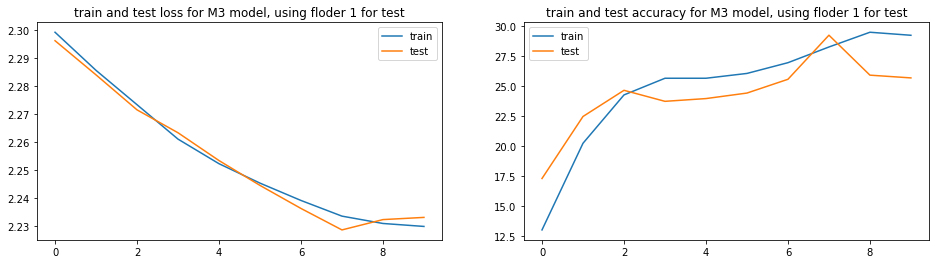

Model M3--test_floder:2 --start_time_floder:2019-12-13 12:50:53.080442
Model M3 --test_floder:2---epoch:1 --- start_time_epoch:2019-12-13 12:50:53.080610
--- Train accuracy mean: 28.07%
--- Test accuracy: 38.85%
Model M3--test_floder mean:2---epoch:1 end_time_epoch:2019-12-13 12:51:15.729563 time_running:0.3774833917617798
Model M3 --test_floder:2---epoch:2 --- start_time_epoch:2019-12-13 12:51:15.730285
--- Train accuracy mean: 28.90%
--- Test accuracy: 39.98%
Model M3--test_floder mean:2---epoch:2 end_time_epoch:2019-12-13 12:51:37.930071 time_running:0.36999785105387367
Model M3 --test_floder:2---epoch:3 --- start_time_epoch:2019-12-13 12:51:37.930738
--- Train accuracy mean: 29.37%
--- Test accuracy: 39.30%
Model M3--test_floder mean:2---epoch:3 end_time_epoch:2019-12-13 12:52:00.290831 time_running:0.37266963720321655
Model M3 --test_floder:2---epoch:4 --- start_time_epoch:2019-12-13 12:52:00.291291
--- Train accuracy mean: 28.98%
--- Test accuracy: 39.08%
Model M3--test_floder me

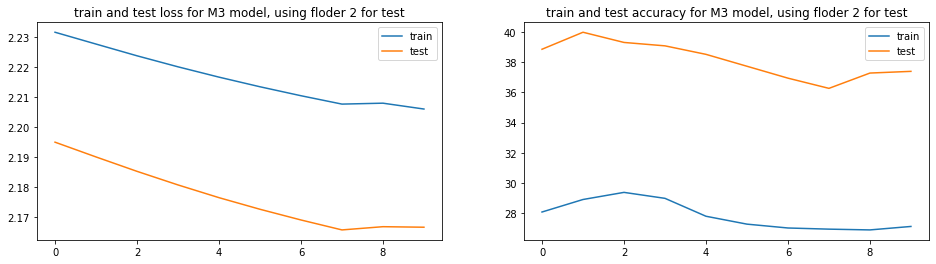

Model M3--test_floder:3 --start_time_floder:2019-12-13 12:54:37.692279
Model M3 --test_floder:3---epoch:1 --- start_time_epoch:2019-12-13 12:54:37.692469
--- Train accuracy mean: 28.26%
--- Test accuracy: 30.05%
Model M3--test_floder mean:3---epoch:1 end_time_epoch:2019-12-13 12:55:00.462269 time_running:0.3794975241025289
Model M3 --test_floder:3---epoch:2 --- start_time_epoch:2019-12-13 12:55:00.462533
--- Train accuracy mean: 28.54%
--- Test accuracy: 30.70%
Model M3--test_floder mean:3---epoch:2 end_time_epoch:2019-12-13 12:55:23.007906 time_running:0.3757566531499227
Model M3 --test_floder:3---epoch:3 --- start_time_epoch:2019-12-13 12:55:23.008545
--- Train accuracy mean: 28.77%
--- Test accuracy: 30.59%
Model M3--test_floder mean:3---epoch:3 end_time_epoch:2019-12-13 12:55:44.848299 time_running:0.36399733225504555
Model M3 --test_floder:3---epoch:4 --- start_time_epoch:2019-12-13 12:55:44.848701
--- Train accuracy mean: 29.13%
--- Test accuracy: 31.03%
Model M3--test_floder mea

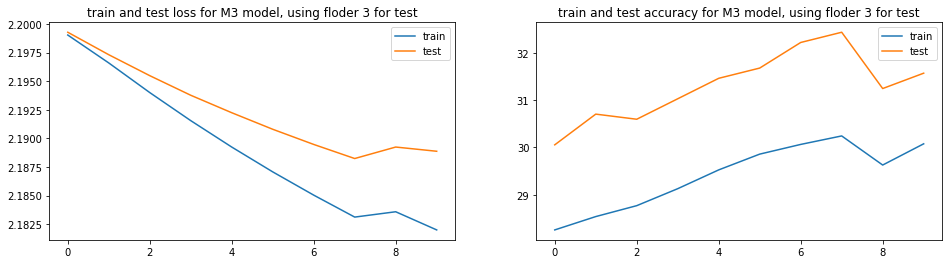

Model M3--test_floder:4 --start_time_floder:2019-12-13 12:58:18.578324
Model M3 --test_floder:4---epoch:1 --- start_time_epoch:2019-12-13 12:58:18.578497
--- Train accuracy mean: 31.23%
--- Test accuracy: 26.87%
Model M3--test_floder mean:4---epoch:1 end_time_epoch:2019-12-13 12:58:40.427903 time_running:0.3641573270161947
Model M3 --test_floder:4---epoch:2 --- start_time_epoch:2019-12-13 12:58:40.428158
--- Train accuracy mean: 31.36%
--- Test accuracy: 26.97%
Model M3--test_floder mean:4---epoch:2 end_time_epoch:2019-12-13 12:59:02.207201 time_running:0.362985626856486
Model M3 --test_floder:4---epoch:3 --- start_time_epoch:2019-12-13 12:59:02.207487
--- Train accuracy mean: 31.58%
--- Test accuracy: 27.07%
Model M3--test_floder mean:4---epoch:3 end_time_epoch:2019-12-13 12:59:24.133733 time_running:0.36543877522150675
Model M3 --test_floder:4---epoch:4 --- start_time_epoch:2019-12-13 12:59:24.133969
--- Train accuracy mean: 31.66%
--- Test accuracy: 27.27%
Model M3--test_floder mean

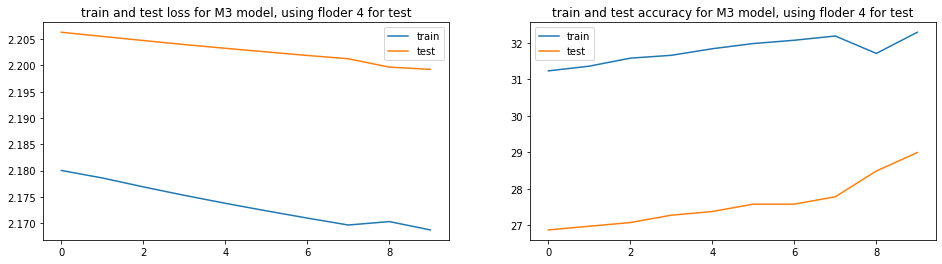

Model M3--test_floder:5 --start_time_floder:2019-12-13 13:01:56.758828
Model M3 --test_floder:5---epoch:1 --- start_time_epoch:2019-12-13 13:01:56.759313
--- Train accuracy mean: 32.66%
--- Test accuracy: 26.28%
Model M3--test_floder mean:5---epoch:1 end_time_epoch:2019-12-13 13:02:18.389747 time_running:0.3605088233947754
Model M3 --test_floder:5---epoch:2 --- start_time_epoch:2019-12-13 13:02:18.390116
--- Train accuracy mean: 32.45%
--- Test accuracy: 26.28%
Model M3--test_floder mean:5---epoch:2 end_time_epoch:2019-12-13 13:02:39.992619 time_running:0.3600447376569112
Model M3 --test_floder:5---epoch:3 --- start_time_epoch:2019-12-13 13:02:39.992878
--- Train accuracy mean: 32.64%
--- Test accuracy: 26.28%
Model M3--test_floder mean:5---epoch:3 end_time_epoch:2019-12-13 13:03:01.346401 time_running:0.35589437882105507
Model M3 --test_floder:5---epoch:4 --- start_time_epoch:2019-12-13 13:03:01.346622
--- Train accuracy mean: 32.80%
--- Test accuracy: 26.50%
Model M3--test_floder mea

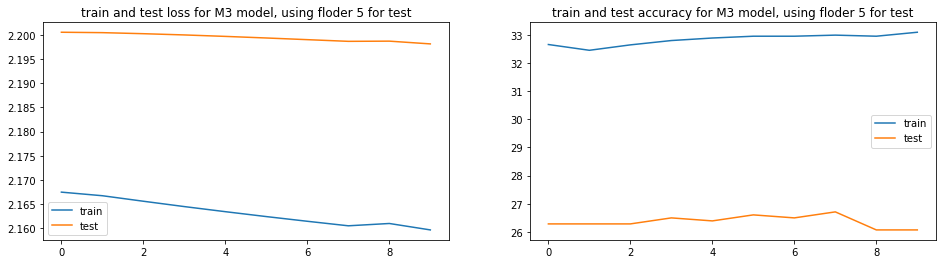

Model M3--test_floder:6 --start_time_floder:2019-12-13 13:05:33.246017
Model M3 --test_floder:6---epoch:1 --- start_time_epoch:2019-12-13 13:05:33.246233
--- Train accuracy mean: 33.10%
--- Test accuracy: 26.97%
Model M3--test_floder mean:6---epoch:1 end_time_epoch:2019-12-13 13:05:54.802262 time_running:0.35926820437113444
Model M3 --test_floder:6---epoch:2 --- start_time_epoch:2019-12-13 13:05:54.802658
--- Train accuracy mean: 33.22%
--- Test accuracy: 26.61%
Model M3--test_floder mean:6---epoch:2 end_time_epoch:2019-12-13 13:06:16.392472 time_running:0.35983177423477175
Model M3 --test_floder:6---epoch:3 --- start_time_epoch:2019-12-13 13:06:16.392694
--- Train accuracy mean: 33.11%
--- Test accuracy: 26.25%
Model M3--test_floder mean:6---epoch:3 end_time_epoch:2019-12-13 13:06:38.266410 time_running:0.3645635525385539
Model M3 --test_floder:6---epoch:4 --- start_time_epoch:2019-12-13 13:06:38.266666
--- Train accuracy mean: 33.29%
--- Test accuracy: 26.12%
Model M3--test_floder me

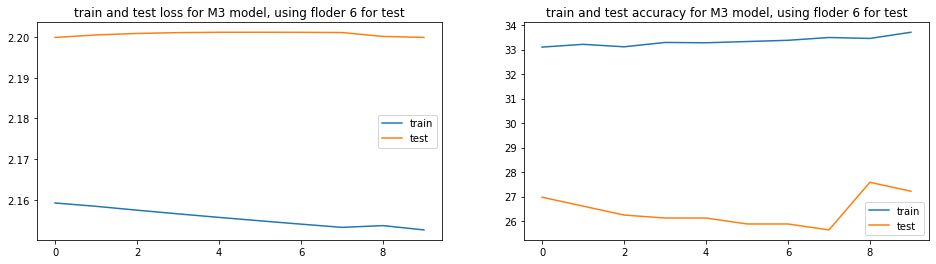

Model M3--test_floder:7 --start_time_floder:2019-12-13 13:09:12.319796
Model M3 --test_floder:7---epoch:1 --- start_time_epoch:2019-12-13 13:09:12.320018
--- Train accuracy mean: 32.44%
--- Test accuracy: 35.44%
Model M3--test_floder mean:7---epoch:1 end_time_epoch:2019-12-13 13:09:34.154019 time_running:0.3639017065366109
Model M3 --test_floder:7---epoch:2 --- start_time_epoch:2019-12-13 13:09:34.154283
--- Train accuracy mean: 32.40%
--- Test accuracy: 34.84%
Model M3--test_floder mean:7---epoch:2 end_time_epoch:2019-12-13 13:09:56.050234 time_running:0.3649346669514974
Model M3 --test_floder:7---epoch:3 --- start_time_epoch:2019-12-13 13:09:56.050467
--- Train accuracy mean: 32.52%
--- Test accuracy: 34.73%
Model M3--test_floder mean:7---epoch:3 end_time_epoch:2019-12-13 13:10:17.973572 time_running:0.3653865814208984
Model M3 --test_floder:7---epoch:4 --- start_time_epoch:2019-12-13 13:10:17.973876
--- Train accuracy mean: 32.57%
--- Test accuracy: 34.84%
Model M3--test_floder mean

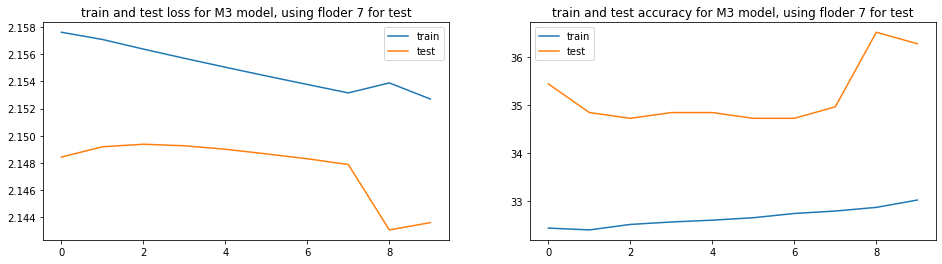

Model M3--test_floder:8 --start_time_floder:2019-12-13 13:12:51.047662
Model M3 --test_floder:8---epoch:1 --- start_time_epoch:2019-12-13 13:12:51.048000
--- Train accuracy mean: 32.94%
--- Test accuracy: 33.87%
Model M3--test_floder mean:8---epoch:1 end_time_epoch:2019-12-13 13:13:12.600980 time_running:0.3592185576756795
Model M3 --test_floder:8---epoch:2 --- start_time_epoch:2019-12-13 13:13:12.601252
--- Train accuracy mean: 33.14%
--- Test accuracy: 33.75%
Model M3--test_floder mean:8---epoch:2 end_time_epoch:2019-12-13 13:13:33.955893 time_running:0.3559122681617737
Model M3 --test_floder:8---epoch:3 --- start_time_epoch:2019-12-13 13:13:33.956219
--- Train accuracy mean: 33.08%
--- Test accuracy: 33.62%
Model M3--test_floder mean:8---epoch:3 end_time_epoch:2019-12-13 13:13:55.509540 time_running:0.35922402143478394
Model M3 --test_floder:8---epoch:4 --- start_time_epoch:2019-12-13 13:13:55.509770
--- Train accuracy mean: 33.16%
--- Test accuracy: 33.50%
Model M3--test_floder mea

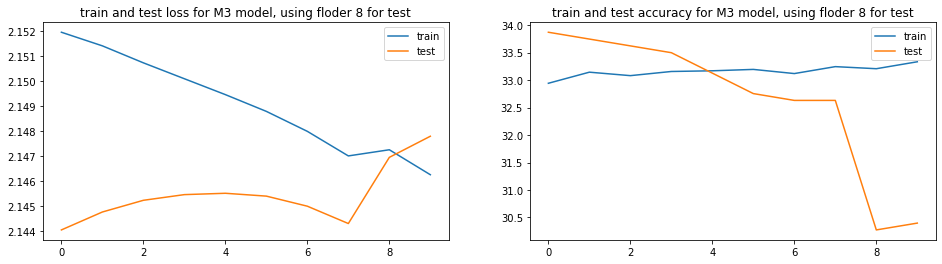

Model M3--test_floder:9 --start_time_floder:2019-12-13 13:16:25.557175
Model M3 --test_floder:9---epoch:1 --- start_time_epoch:2019-12-13 13:16:25.557646
--- Train accuracy mean: 33.88%
--- Test accuracy: 23.90%
Model M3--test_floder mean:9---epoch:1 end_time_epoch:2019-12-13 13:16:47.007693 time_running:0.3575017213821411
Model M3 --test_floder:9---epoch:2 --- start_time_epoch:2019-12-13 13:16:47.008890
--- Train accuracy mean: 33.78%
--- Test accuracy: 24.02%
Model M3--test_floder mean:9---epoch:2 end_time_epoch:2019-12-13 13:17:08.442735 time_running:0.357249120871226
Model M3 --test_floder:9---epoch:3 --- start_time_epoch:2019-12-13 13:17:08.442992
--- Train accuracy mean: 34.08%
--- Test accuracy: 24.02%
Model M3--test_floder mean:9---epoch:3 end_time_epoch:2019-12-13 13:17:30.003058 time_running:0.35933622121810915
Model M3 --test_floder:9---epoch:4 --- start_time_epoch:2019-12-13 13:17:30.003317
--- Train accuracy mean: 34.21%
--- Test accuracy: 24.14%
Model M3--test_floder mean

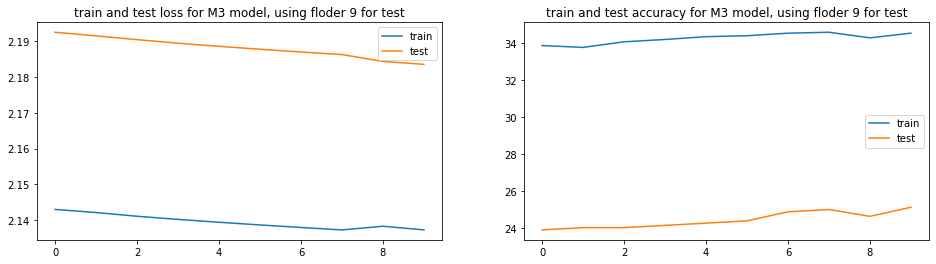

Model M3--test_floder:10 --start_time_floder:2019-12-13 13:20:00.553572
Model M3 --test_floder:10---epoch:1 --- start_time_epoch:2019-12-13 13:20:00.553711
--- Train accuracy mean: 33.88%
--- Test accuracy: 33.69%
Model M3--test_floder mean:10---epoch:1 end_time_epoch:2019-12-13 13:20:22.386398 time_running:0.3638787786165873
Model M3 --test_floder:10---epoch:2 --- start_time_epoch:2019-12-13 13:20:22.386581
--- Train accuracy mean: 34.06%
--- Test accuracy: 33.33%
Model M3--test_floder mean:10---epoch:2 end_time_epoch:2019-12-13 13:20:44.277614 time_running:0.3648518840471903
Model M3 --test_floder:10---epoch:3 --- start_time_epoch:2019-12-13 13:20:44.277917
--- Train accuracy mean: 34.14%
--- Test accuracy: 33.21%
Model M3--test_floder mean:10---epoch:3 end_time_epoch:2019-12-13 13:21:05.915099 time_running:0.36062150398890175
Model M3 --test_floder:10---epoch:4 --- start_time_epoch:2019-12-13 13:21:05.915339
--- Train accuracy mean: 34.22%
--- Test accuracy: 33.21%
Model M3--test_fl

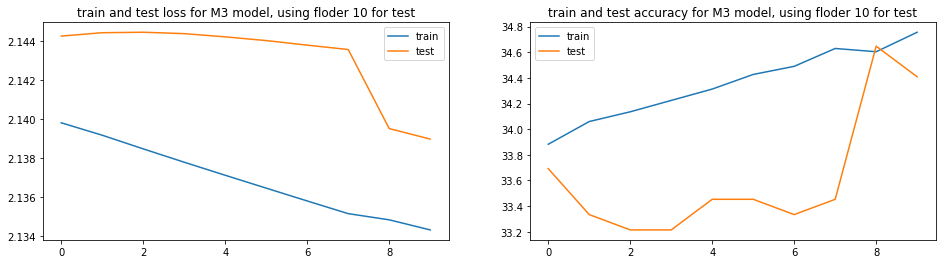

Model M3-----------end_time_model:2019-12-13 13:23:38.048332 with cross validation loss:2.1789423959595817 and cross validation accuracy:31.50574299760866


In [24]:
print(" .      ***************************************************************************************************")
print("**************************************************MODEL M3*************************************************")
print(" .      ***************************************************************************************************")
model = M3
model_train_plot(model,"M3")

 .      ***************************************************************************************************
**************************************************MODEL M5*************************************************
 .      ***************************************************************************************************
Model M5-----------start_time_model:2019-12-13 14:39:49.841838
Model M5--test_floder:1 --start_time_floder:2019-12-13 14:39:55.921737
Model M5 --test_floder:1---epoch:1 --- start_time_epoch:2019-12-13 14:39:55.922278
--- Train accuracy mean: 17.49%
--- Test accuracy: 24.63%
Model M5--test_floder mean:1---epoch:1 end_time_epoch:2019-12-13 14:40:19.607095 time_running:0.39474759101867674
Model M5 --test_floder:1---epoch:2 --- start_time_epoch:2019-12-13 14:40:19.607819
--- Train accuracy mean: 25.09%
--- Test accuracy: 25.77%
Model M5--test_floder mean:1---epoch:2 end_time_epoch:2019-12-13 14:40:43.153768 time_running:0.3924347559611003
Model M5 --test_floder:1---epoch:

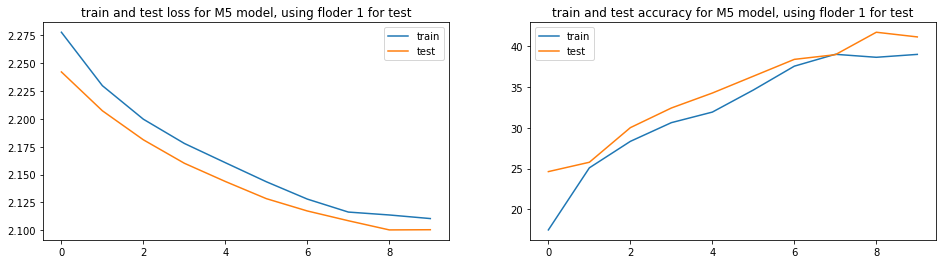

Model M5--test_floder:2 --start_time_floder:2019-12-13 14:43:52.265368
Model M5 --test_floder:2---epoch:1 --- start_time_epoch:2019-12-13 14:43:52.265573
--- Train accuracy mean: 38.65%
--- Test accuracy: 42.23%
Model M5--test_floder mean:2---epoch:1 end_time_epoch:2019-12-13 14:44:13.907795 time_running:0.36070510546366374
Model M5 --test_floder:2---epoch:2 --- start_time_epoch:2019-12-13 14:44:13.908044
--- Train accuracy mean: 38.86%
--- Test accuracy: 40.77%
Model M5--test_floder mean:2---epoch:2 end_time_epoch:2019-12-13 14:44:35.226279 time_running:0.3553057909011841
Model M5 --test_floder:2---epoch:3 --- start_time_epoch:2019-12-13 14:44:35.226529
--- Train accuracy mean: 39.33%
--- Test accuracy: 40.32%
Model M5--test_floder mean:2---epoch:3 end_time_epoch:2019-12-13 14:44:56.425953 time_running:0.35332589149475097
Model M5 --test_floder:2---epoch:4 --- start_time_epoch:2019-12-13 14:44:56.426294
--- Train accuracy mean: 39.78%
--- Test accuracy: 39.08%
Model M5--test_floder me

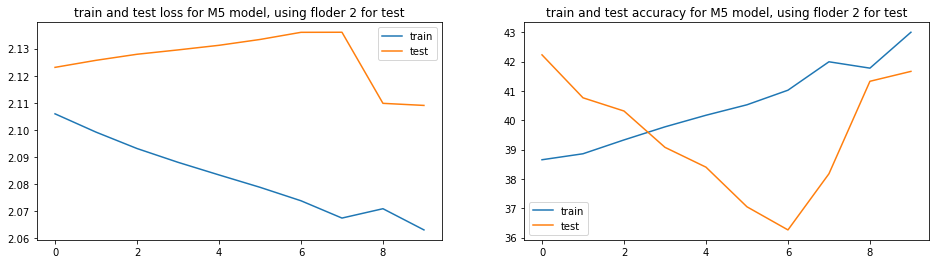

Model M5--test_floder:3 --start_time_floder:2019-12-13 14:47:26.406815
Model M5 --test_floder:3---epoch:1 --- start_time_epoch:2019-12-13 14:47:26.407379
--- Train accuracy mean: 43.29%
--- Test accuracy: 38.92%
Model M5--test_floder mean:3---epoch:1 end_time_epoch:2019-12-13 14:47:48.334918 time_running:0.36546059846878054
Model M5 --test_floder:3---epoch:2 --- start_time_epoch:2019-12-13 14:47:48.335605
--- Train accuracy mean: 44.26%
--- Test accuracy: 37.84%
Model M5--test_floder mean:3---epoch:2 end_time_epoch:2019-12-13 14:48:10.352874 time_running:0.3669563293457031
Model M5 --test_floder:3---epoch:3 --- start_time_epoch:2019-12-13 14:48:10.353151
--- Train accuracy mean: 44.77%
--- Test accuracy: 37.62%
Model M5--test_floder mean:3---epoch:3 end_time_epoch:2019-12-13 14:48:32.249038 time_running:0.36493353843688964
Model M5 --test_floder:3---epoch:4 --- start_time_epoch:2019-12-13 14:48:32.249423
--- Train accuracy mean: 45.19%
--- Test accuracy: 37.62%
Model M5--test_floder me

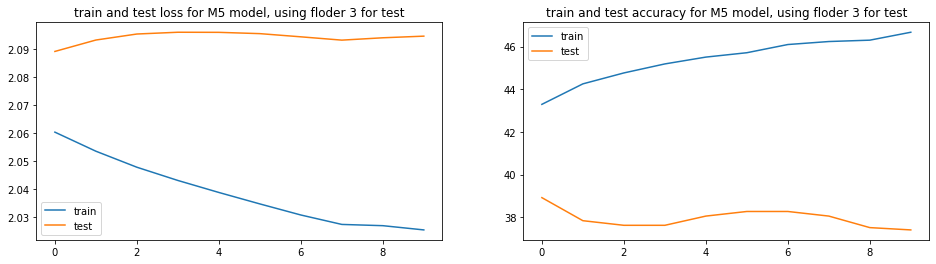

Model M5--test_floder:4 --start_time_floder:2019-12-13 14:51:02.784958
Model M5 --test_floder:4---epoch:1 --- start_time_epoch:2019-12-13 14:51:02.785574
--- Train accuracy mean: 45.79%
--- Test accuracy: 43.94%
Model M5--test_floder mean:4---epoch:1 end_time_epoch:2019-12-13 14:51:24.192012 time_running:0.35677539904912314
Model M5 --test_floder:4---epoch:2 --- start_time_epoch:2019-12-13 14:51:24.193032
--- Train accuracy mean: 46.44%
--- Test accuracy: 43.43%
Model M5--test_floder mean:4---epoch:2 end_time_epoch:2019-12-13 14:51:45.819797 time_running:0.3604489286740621
Model M5 --test_floder:4---epoch:3 --- start_time_epoch:2019-12-13 14:51:45.820078
--- Train accuracy mean: 46.82%
--- Test accuracy: 43.54%
Model M5--test_floder mean:4---epoch:3 end_time_epoch:2019-12-13 14:52:07.360072 time_running:0.35900235573450723
Model M5 --test_floder:4---epoch:4 --- start_time_epoch:2019-12-13 14:52:07.360491
--- Train accuracy mean: 47.11%
--- Test accuracy: 43.33%
Model M5--test_floder me

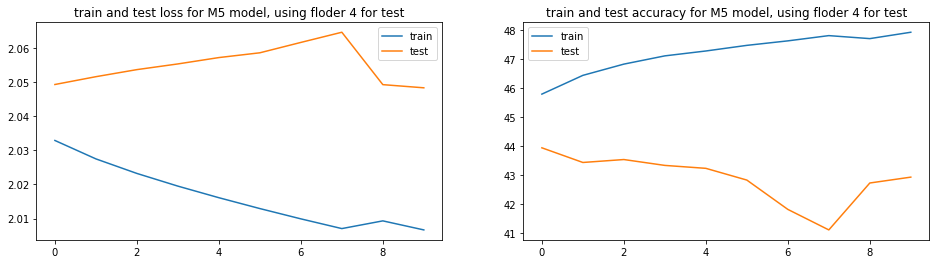

Model M5--test_floder:5 --start_time_floder:2019-12-13 14:54:39.447194
Model M5 --test_floder:5---epoch:1 --- start_time_epoch:2019-12-13 14:54:39.447718
--- Train accuracy mean: 47.82%
--- Test accuracy: 46.05%
Model M5--test_floder mean:5---epoch:1 end_time_epoch:2019-12-13 14:55:00.923366 time_running:0.35792938868204754
Model M5 --test_floder:5---epoch:2 --- start_time_epoch:2019-12-13 14:55:00.923676
--- Train accuracy mean: 47.95%
--- Test accuracy: 46.15%
Model M5--test_floder mean:5---epoch:2 end_time_epoch:2019-12-13 14:55:22.311377 time_running:0.3564649820327759
Model M5 --test_floder:5---epoch:3 --- start_time_epoch:2019-12-13 14:55:22.311591
--- Train accuracy mean: 48.26%
--- Test accuracy: 45.94%
Model M5--test_floder mean:5---epoch:3 end_time_epoch:2019-12-13 14:55:43.514729 time_running:0.3533874869346619
Model M5 --test_floder:5---epoch:4 --- start_time_epoch:2019-12-13 14:55:43.515064
--- Train accuracy mean: 48.63%
--- Test accuracy: 45.94%
Model M5--test_floder mea

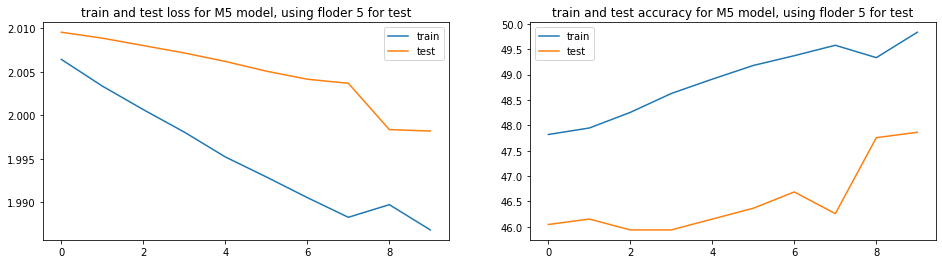

Model M5--test_floder:6 --start_time_floder:2019-12-13 14:58:13.567059
Model M5 --test_floder:6---epoch:1 --- start_time_epoch:2019-12-13 14:58:13.567293
--- Train accuracy mean: 50.52%
--- Test accuracy: 40.58%
Model M5--test_floder mean:6---epoch:1 end_time_epoch:2019-12-13 14:58:35.048213 time_running:0.35801692803700763
Model M5 --test_floder:6---epoch:2 --- start_time_epoch:2019-12-13 14:58:35.048428
--- Train accuracy mean: 50.71%
--- Test accuracy: 40.58%
Model M5--test_floder mean:6---epoch:2 end_time_epoch:2019-12-13 14:58:56.566944 time_running:0.35864393711090087
Model M5 --test_floder:6---epoch:3 --- start_time_epoch:2019-12-13 14:58:56.567192
--- Train accuracy mean: 50.76%
--- Test accuracy: 40.70%
Model M5--test_floder mean:6---epoch:3 end_time_epoch:2019-12-13 14:59:18.285446 time_running:0.36197293599446617
Model M5 --test_floder:6---epoch:4 --- start_time_epoch:2019-12-13 14:59:18.285905
--- Train accuracy mean: 50.93%
--- Test accuracy: 40.70%
Model M5--test_floder m

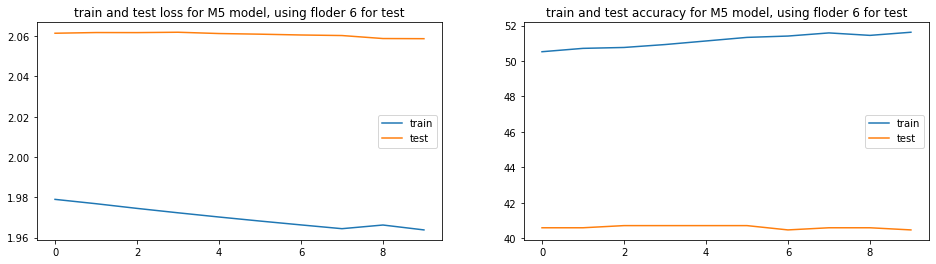

Model M5--test_floder:7 --start_time_floder:2019-12-13 15:01:49.513661
Model M5 --test_floder:7---epoch:1 --- start_time_epoch:2019-12-13 15:01:49.514096
--- Train accuracy mean: 50.89%
--- Test accuracy: 41.77%
Model M5--test_floder mean:7---epoch:1 end_time_epoch:2019-12-13 15:02:11.143259 time_running:0.3604872385660807
Model M5 --test_floder:7---epoch:2 --- start_time_epoch:2019-12-13 15:02:11.143813
--- Train accuracy mean: 51.08%
--- Test accuracy: 41.53%
Model M5--test_floder mean:7---epoch:2 end_time_epoch:2019-12-13 15:02:32.757075 time_running:0.3602246165275574
Model M5 --test_floder:7---epoch:3 --- start_time_epoch:2019-12-13 15:02:32.757358
--- Train accuracy mean: 51.27%
--- Test accuracy: 41.41%
Model M5--test_floder mean:7---epoch:3 end_time_epoch:2019-12-13 15:02:54.246119 time_running:0.35814732710520425
Model M5 --test_floder:7---epoch:4 --- start_time_epoch:2019-12-13 15:02:54.246461
--- Train accuracy mean: 51.63%
--- Test accuracy: 40.93%
Model M5--test_floder mea

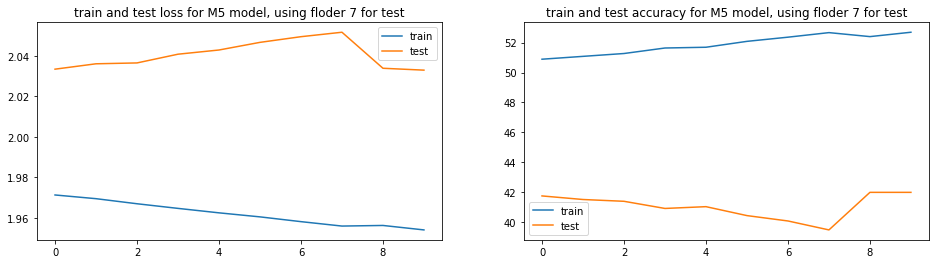

Model M5--test_floder:8 --start_time_floder:2019-12-13 15:05:25.983039
Model M5 --test_floder:8---epoch:1 --- start_time_epoch:2019-12-13 15:05:25.983243
--- Train accuracy mean: 51.78%
--- Test accuracy: 54.34%
Model M5--test_floder mean:8---epoch:1 end_time_epoch:2019-12-13 15:05:47.738420 time_running:0.36258753935496013
Model M5 --test_floder:8---epoch:2 --- start_time_epoch:2019-12-13 15:05:47.738791
--- Train accuracy mean: 52.04%
--- Test accuracy: 54.34%
Model M5--test_floder mean:8---epoch:2 end_time_epoch:2019-12-13 15:06:09.331553 time_running:0.35988159974416095
Model M5 --test_floder:8---epoch:3 --- start_time_epoch:2019-12-13 15:06:09.332215
--- Train accuracy mean: 52.38%
--- Test accuracy: 54.47%
Model M5--test_floder mean:8---epoch:3 end_time_epoch:2019-12-13 15:06:30.944896 time_running:0.36021358172098794
Model M5 --test_floder:8---epoch:4 --- start_time_epoch:2019-12-13 15:06:30.945418
--- Train accuracy mean: 52.66%
--- Test accuracy: 54.71%
Model M5--test_floder m

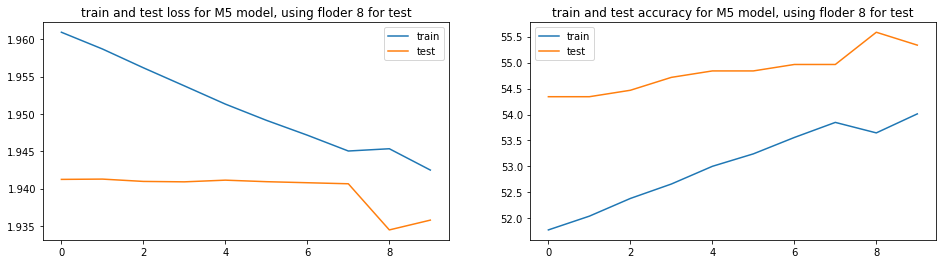

Model M5--test_floder:9 --start_time_floder:2019-12-13 15:09:02.694429
Model M5 --test_floder:9---epoch:1 --- start_time_epoch:2019-12-13 15:09:02.694788
--- Train accuracy mean: 53.84%
--- Test accuracy: 55.02%
Model M5--test_floder mean:9---epoch:1 end_time_epoch:2019-12-13 15:09:24.252292 time_running:0.3592947483062744
Model M5 --test_floder:9---epoch:2 --- start_time_epoch:2019-12-13 15:09:24.253020
--- Train accuracy mean: 54.06%
--- Test accuracy: 54.90%
Model M5--test_floder mean:9---epoch:2 end_time_epoch:2019-12-13 15:09:45.672253 time_running:0.3569902380307515
Model M5 --test_floder:9---epoch:3 --- start_time_epoch:2019-12-13 15:09:45.674005
--- Train accuracy mean: 54.19%
--- Test accuracy: 54.41%
Model M5--test_floder mean:9---epoch:3 end_time_epoch:2019-12-13 15:10:07.279323 time_running:0.3600904901822408
Model M5 --test_floder:9---epoch:4 --- start_time_epoch:2019-12-13 15:10:07.279787
--- Train accuracy mean: 54.43%
--- Test accuracy: 54.17%
Model M5--test_floder mean

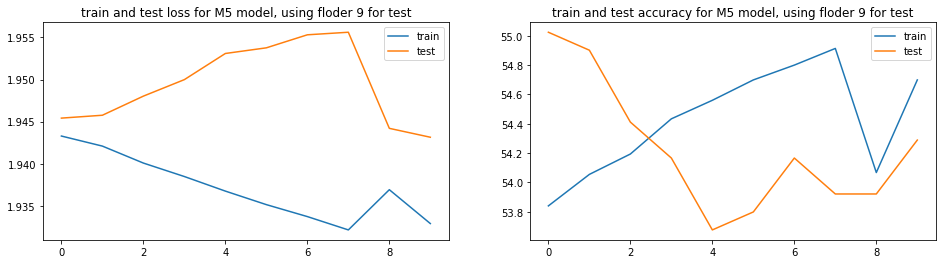

Model M5--test_floder:10 --start_time_floder:2019-12-13 15:12:38.735209
Model M5 --test_floder:10---epoch:1 --- start_time_epoch:2019-12-13 15:12:38.735436
--- Train accuracy mean: 55.48%
--- Test accuracy: 50.42%
Model M5--test_floder mean:10---epoch:1 end_time_epoch:2019-12-13 15:13:00.745601 time_running:0.366837739944458
Model M5 --test_floder:10---epoch:2 --- start_time_epoch:2019-12-13 15:13:00.745894
--- Train accuracy mean: 55.77%
--- Test accuracy: 51.02%
Model M5--test_floder mean:10---epoch:2 end_time_epoch:2019-12-13 15:13:22.728017 time_running:0.36637084086736044
Model M5 --test_floder:10---epoch:3 --- start_time_epoch:2019-12-13 15:13:22.729253
--- Train accuracy mean: 56.05%
--- Test accuracy: 50.78%
Model M5--test_floder mean:10---epoch:3 end_time_epoch:2019-12-13 15:13:44.510454 time_running:0.3630225936571757
Model M5 --test_floder:10---epoch:4 --- start_time_epoch:2019-12-13 15:13:44.510764
--- Train accuracy mean: 56.19%
--- Test accuracy: 50.66%
Model M5--test_flo

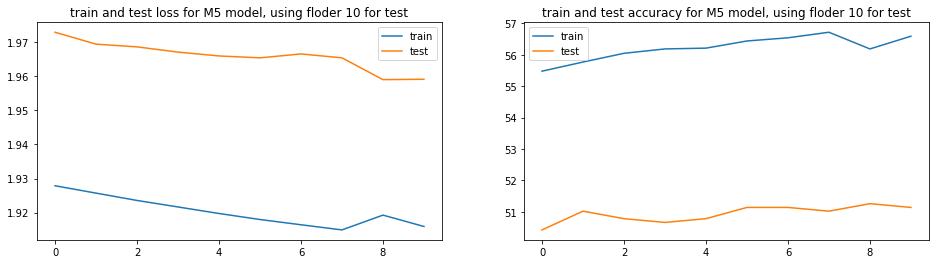

Model M5-----------end_time_model:2019-12-13 15:16:18.554081 with cross validation loss:2.0273239533816065 and cross validation accuracy:45.921822255038116


In [26]:
print(" .      ***************************************************************************************************")
print("**************************************************MODEL M5*************************************************")
print(" .      ***************************************************************************************************")
model = M5
model_train_plot(model,"M5")

 .      ***************************************************************************************************
**************************************************MODEL M11*************************************************
 .      ***************************************************************************************************
Model M11-----------start_time_model:2019-12-13 15:57:55.216609
Model M11--test_floder:1 --start_time_floder:2019-12-13 15:57:55.277386
Model M11 --test_floder:1---epoch:1 --- start_time_epoch:2019-12-13 15:57:55.277829
--- Train accuracy mean: 17.69%
--- Test accuracy: 26.23%
Model M11--test_floder mean:1---epoch:1 end_time_epoch:2019-12-13 15:58:19.721202 time_running:0.40739166339238486
Model M11 --test_floder:1---epoch:2 --- start_time_epoch:2019-12-13 15:58:19.721570
--- Train accuracy mean: 29.26%
--- Test accuracy: 31.50%
Model M11--test_floder mean:1---epoch:2 end_time_epoch:2019-12-13 15:58:44.097065 time_running:0.40626127322514854
Model M11 --test_floder:1

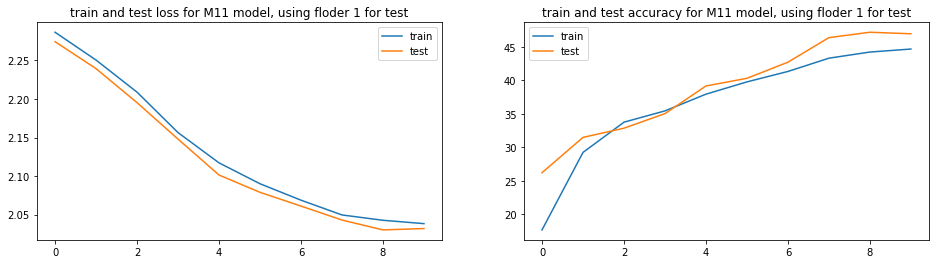

Model M11--test_floder:2 --start_time_floder:2019-12-13 16:02:01.862347
Model M11 --test_floder:2---epoch:1 --- start_time_epoch:2019-12-13 16:02:01.862762
--- Train accuracy mean: 45.23%
--- Test accuracy: 42.00%
Model M11--test_floder mean:2---epoch:1 end_time_epoch:2019-12-13 16:02:24.375748 time_running:0.37522015571594236
Model M11 --test_floder:2---epoch:2 --- start_time_epoch:2019-12-13 16:02:24.376739
--- Train accuracy mean: 47.28%
--- Test accuracy: 41.55%
Model M11--test_floder mean:2---epoch:2 end_time_epoch:2019-12-13 16:02:46.428442 time_running:0.3675328811009725
Model M11 --test_floder:2---epoch:3 --- start_time_epoch:2019-12-13 16:02:46.428853
--- Train accuracy mean: 49.53%
--- Test accuracy: 43.02%
Model M11--test_floder mean:2---epoch:3 end_time_epoch:2019-12-13 16:03:08.746035 time_running:0.37195667425791423
Model M11 --test_floder:2---epoch:4 --- start_time_epoch:2019-12-13 16:03:08.746776
--- Train accuracy mean: 52.14%
--- Test accuracy: 44.03%
Model M11--test_

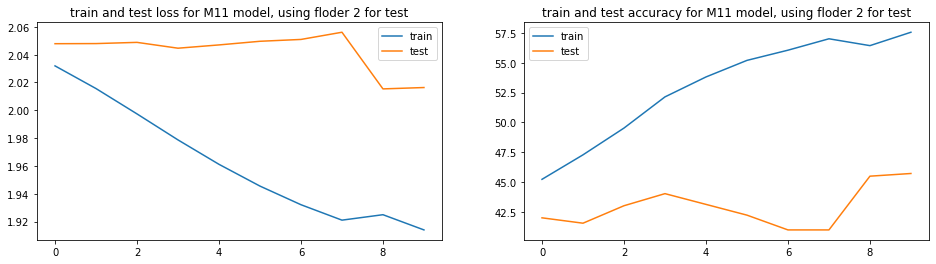

Model M11--test_floder:3 --start_time_floder:2019-12-13 16:05:45.129289
Model M11 --test_floder:3---epoch:1 --- start_time_epoch:2019-12-13 16:05:45.129954
--- Train accuracy mean: 58.15%
--- Test accuracy: 43.24%
Model M11--test_floder mean:3---epoch:1 end_time_epoch:2019-12-13 16:06:07.566817 time_running:0.37395008007685343
Model M11 --test_floder:3---epoch:2 --- start_time_epoch:2019-12-13 16:06:07.567267
--- Train accuracy mean: 59.31%
--- Test accuracy: 42.92%
Model M11--test_floder mean:3---epoch:2 end_time_epoch:2019-12-13 16:06:29.901203 time_running:0.37223763863245646
Model M11 --test_floder:3---epoch:3 --- start_time_epoch:2019-12-13 16:06:29.902787
--- Train accuracy mean: 60.70%
--- Test accuracy: 43.68%
Model M11--test_floder mean:3---epoch:3 end_time_epoch:2019-12-13 16:06:52.177445 time_running:0.3712667107582092
Model M11 --test_floder:3---epoch:4 --- start_time_epoch:2019-12-13 16:06:52.177876
--- Train accuracy mean: 61.78%
--- Test accuracy: 42.81%
Model M11--test_

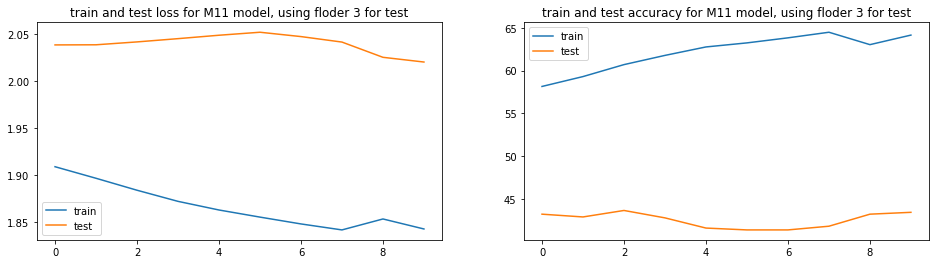

Model M11--test_floder:4 --start_time_floder:2019-12-13 16:09:29.387048
Model M11 --test_floder:4---epoch:1 --- start_time_epoch:2019-12-13 16:09:29.387407
--- Train accuracy mean: 62.57%
--- Test accuracy: 55.25%
Model M11--test_floder mean:4---epoch:1 end_time_epoch:2019-12-13 16:09:52.173708 time_running:0.3797751426696777
Model M11 --test_floder:4---epoch:2 --- start_time_epoch:2019-12-13 16:09:52.174495
--- Train accuracy mean: 63.92%
--- Test accuracy: 55.05%
Model M11--test_floder mean:4---epoch:2 end_time_epoch:2019-12-13 16:10:14.287745 time_running:0.3685573180516561
Model M11 --test_floder:4---epoch:3 --- start_time_epoch:2019-12-13 16:10:14.288910
--- Train accuracy mean: 65.03%
--- Test accuracy: 55.35%
Model M11--test_floder mean:4---epoch:3 end_time_epoch:2019-12-13 16:10:36.592008 time_running:0.3717235287030538
Model M11 --test_floder:4---epoch:4 --- start_time_epoch:2019-12-13 16:10:36.592353
--- Train accuracy mean: 65.91%
--- Test accuracy: 55.35%
Model M11--test_fl

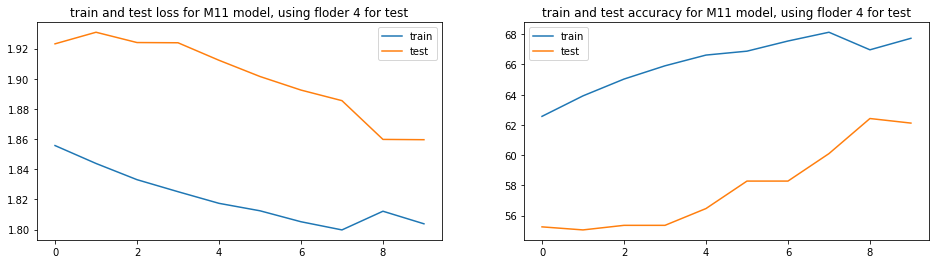

Model M11--test_floder:5 --start_time_floder:2019-12-13 16:13:13.257367
Model M11 --test_floder:5---epoch:1 --- start_time_epoch:2019-12-13 16:13:13.258077
--- Train accuracy mean: 68.06%
--- Test accuracy: 62.93%
Model M11--test_floder mean:5---epoch:1 end_time_epoch:2019-12-13 16:13:35.710077 time_running:0.3742024501164754
Model M11 --test_floder:5---epoch:2 --- start_time_epoch:2019-12-13 16:13:35.710609
--- Train accuracy mean: 68.89%
--- Test accuracy: 60.79%
Model M11--test_floder mean:5---epoch:2 end_time_epoch:2019-12-13 16:13:58.354008 time_running:0.377393893400828
Model M11 --test_floder:5---epoch:3 --- start_time_epoch:2019-12-13 16:13:58.354291
--- Train accuracy mean: 69.87%
--- Test accuracy: 58.76%
Model M11--test_floder mean:5---epoch:3 end_time_epoch:2019-12-13 16:14:20.874992 time_running:0.3753481864929199
Model M11 --test_floder:5---epoch:4 --- start_time_epoch:2019-12-13 16:14:20.875405
--- Train accuracy mean: 70.37%
--- Test accuracy: 57.80%
Model M11--test_flo

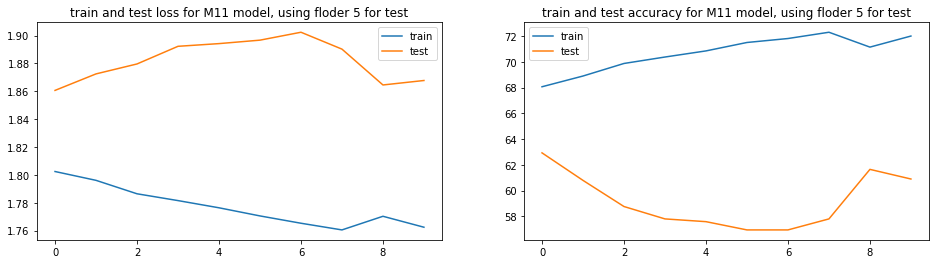

Model M11--test_floder:6 --start_time_floder:2019-12-13 16:16:59.538062
Model M11 --test_floder:6---epoch:1 --- start_time_epoch:2019-12-13 16:16:59.538725
--- Train accuracy mean: 70.38%
--- Test accuracy: 58.93%
Model M11--test_floder mean:6---epoch:1 end_time_epoch:2019-12-13 16:17:21.959300 time_running:0.3736800154050191
Model M11 --test_floder:6---epoch:2 --- start_time_epoch:2019-12-13 16:17:21.960101
--- Train accuracy mean: 71.31%
--- Test accuracy: 60.02%
Model M11--test_floder mean:6---epoch:2 end_time_epoch:2019-12-13 16:17:44.287939 time_running:0.372135591506958
Model M11 --test_floder:6---epoch:3 --- start_time_epoch:2019-12-13 16:17:44.288227
--- Train accuracy mean: 71.84%
--- Test accuracy: 59.66%
Model M11--test_floder mean:6---epoch:3 end_time_epoch:2019-12-13 16:18:06.610716 time_running:0.37204444805781045
Model M11 --test_floder:6---epoch:4 --- start_time_epoch:2019-12-13 16:18:06.611414
--- Train accuracy mean: 72.34%
--- Test accuracy: 57.59%
Model M11--test_fl

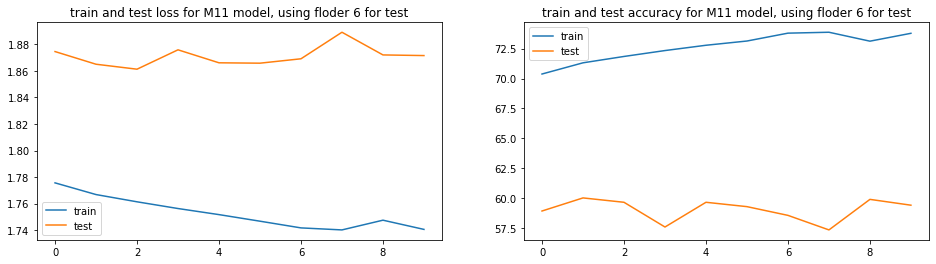

Model M11--test_floder:7 --start_time_floder:2019-12-13 16:20:43.364053
Model M11 --test_floder:7---epoch:1 --- start_time_epoch:2019-12-13 16:20:43.364316
--- Train accuracy mean: 72.60%
--- Test accuracy: 61.93%
Model M11--test_floder mean:7---epoch:1 end_time_epoch:2019-12-13 16:21:05.713206 time_running:0.37248339255650836
Model M11 --test_floder:7---epoch:2 --- start_time_epoch:2019-12-13 16:21:05.713600
--- Train accuracy mean: 73.22%
--- Test accuracy: 58.11%
Model M11--test_floder mean:7---epoch:2 end_time_epoch:2019-12-13 16:21:28.302099 time_running:0.37647896210352577
Model M11 --test_floder:7---epoch:3 --- start_time_epoch:2019-12-13 16:21:28.302532
--- Train accuracy mean: 73.89%
--- Test accuracy: 59.07%
Model M11--test_floder mean:7---epoch:3 end_time_epoch:2019-12-13 16:21:50.998115 time_running:0.3782653013865153
Model M11 --test_floder:7---epoch:4 --- start_time_epoch:2019-12-13 16:21:50.998455
--- Train accuracy mean: 74.41%
--- Test accuracy: 61.81%
Model M11--test_

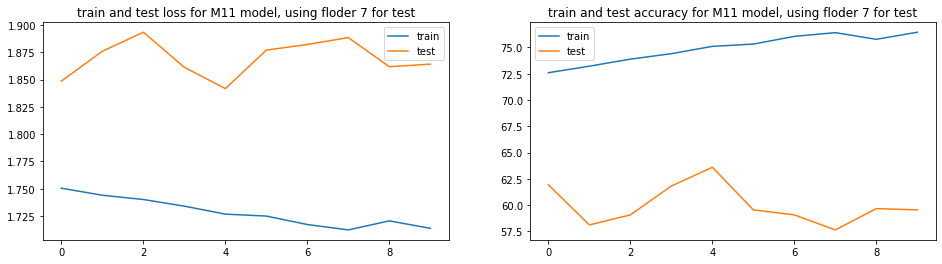

Model M11--test_floder:8 --start_time_floder:2019-12-13 16:24:29.547224
Model M11 --test_floder:8---epoch:1 --- start_time_epoch:2019-12-13 16:24:29.547950
--- Train accuracy mean: 74.10%
--- Test accuracy: 73.20%
Model M11--test_floder mean:8---epoch:1 end_time_epoch:2019-12-13 16:24:51.878493 time_running:0.3721788247426351
Model M11 --test_floder:8---epoch:2 --- start_time_epoch:2019-12-13 16:24:51.878945
--- Train accuracy mean: 75.16%
--- Test accuracy: 71.59%
Model M11--test_floder mean:8---epoch:2 end_time_epoch:2019-12-13 16:25:14.337336 time_running:0.37430959145228065
Model M11 --test_floder:8---epoch:3 --- start_time_epoch:2019-12-13 16:25:14.337759
--- Train accuracy mean: 76.17%
--- Test accuracy: 70.97%
Model M11--test_floder mean:8---epoch:3 end_time_epoch:2019-12-13 16:25:36.334995 time_running:0.3666247765223185
Model M11 --test_floder:8---epoch:4 --- start_time_epoch:2019-12-13 16:25:36.335316
--- Train accuracy mean: 76.70%
--- Test accuracy: 73.45%
Model M11--test_f

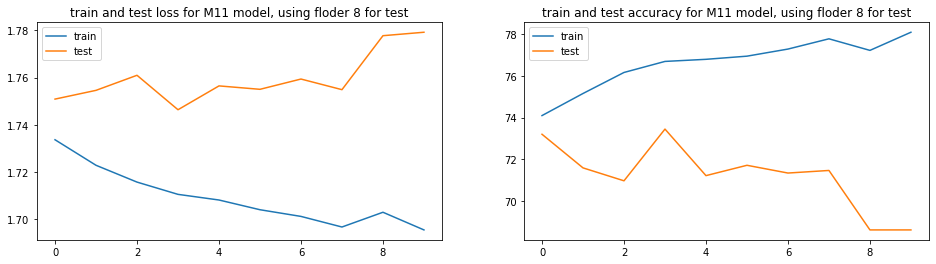

Model M11--test_floder:9 --start_time_floder:2019-12-13 16:28:12.333704
Model M11 --test_floder:9---epoch:1 --- start_time_epoch:2019-12-13 16:28:12.334326
--- Train accuracy mean: 76.95%
--- Test accuracy: 65.32%
Model M11--test_floder mean:9---epoch:1 end_time_epoch:2019-12-13 16:28:34.729040 time_running:0.3732479969660441
Model M11 --test_floder:9---epoch:2 --- start_time_epoch:2019-12-13 16:28:34.729445
--- Train accuracy mean: 77.68%
--- Test accuracy: 71.57%
Model M11--test_floder mean:9---epoch:2 end_time_epoch:2019-12-13 16:28:57.718625 time_running:0.3831565340360006
Model M11 --test_floder:9---epoch:3 --- start_time_epoch:2019-12-13 16:28:57.720093
--- Train accuracy mean: 77.98%
--- Test accuracy: 71.94%
Model M11--test_floder mean:9---epoch:3 end_time_epoch:2019-12-13 16:29:20.534570 time_running:0.3802445848782857
Model M11 --test_floder:9---epoch:4 --- start_time_epoch:2019-12-13 16:29:20.534989
--- Train accuracy mean: 78.52%
--- Test accuracy: 70.71%
Model M11--test_fl

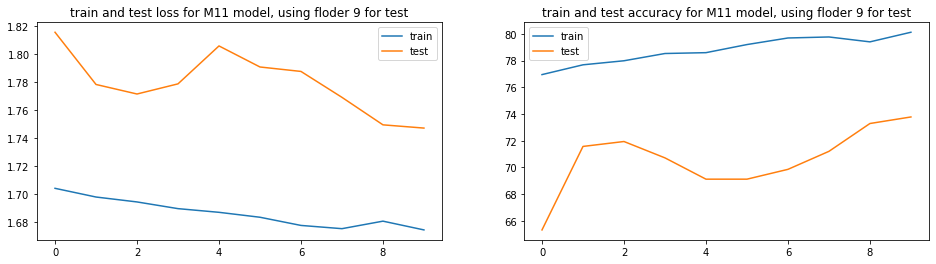

Model M11--test_floder:10 --start_time_floder:2019-12-13 16:32:01.080981
Model M11 --test_floder:10---epoch:1 --- start_time_epoch:2019-12-13 16:32:01.081233
--- Train accuracy mean: 78.90%
--- Test accuracy: 65.59%
Model M11--test_floder mean:10---epoch:1 end_time_epoch:2019-12-13 16:32:23.723410 time_running:0.377371601263682
Model M11 --test_floder:10---epoch:2 --- start_time_epoch:2019-12-13 16:32:23.723746
--- Train accuracy mean: 79.44%
--- Test accuracy: 67.86%
Model M11--test_floder mean:10---epoch:2 end_time_epoch:2019-12-13 16:32:46.351566 time_running:0.3771342396736145
Model M11 --test_floder:10---epoch:3 --- start_time_epoch:2019-12-13 16:32:46.352175
--- Train accuracy mean: 80.33%
--- Test accuracy: 66.55%
Model M11--test_floder mean:10---epoch:3 end_time_epoch:2019-12-13 16:33:09.202561 time_running:0.3808428724606832
Model M11 --test_floder:10---epoch:4 --- start_time_epoch:2019-12-13 16:33:09.202942
--- Train accuracy mean: 80.91%
--- Test accuracy: 68.22%
Model M11--

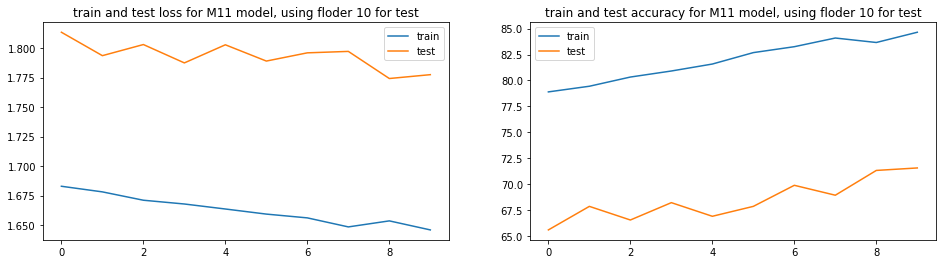

Model M11-----------end_time_model:2019-12-13 16:35:48.634406 with cross validation loss:1.8756538167595864 and cross validation accuracy:60.4358448699435


In [29]:
print(" .      ***************************************************************************************************")
print("**************************************************MODEL M11*************************************************")
print(" .      ***************************************************************************************************")
model = M11
model_train_plot(model,"M11")

 .      ***************************************************************************************************
**************************************************MODEL M18*************************************************
 .      ***************************************************************************************************
Model M18-----------start_time_model:2019-12-13 15:16:18.587688
Model M18--test_floder:1 --start_time_floder:2019-12-13 15:16:18.653677
Model M18 --test_floder:1---epoch:1 --- start_time_epoch:2019-12-13 15:16:18.654010
--- Train accuracy mean: 15.16%
--- Test accuracy: 15.35%
Model M18--test_floder mean:1---epoch:1 end_time_epoch:2019-12-13 15:16:44.104857 time_running:0.42418413956960044
Model M18 --test_floder:1---epoch:2 --- start_time_epoch:2019-12-13 15:16:44.105310
--- Train accuracy mean: 23.22%
--- Test accuracy: 19.59%
Model M18--test_floder mean:1---epoch:2 end_time_epoch:2019-12-13 15:17:09.412869 time_running:0.4217976967493693
Model M18 --test_floder:1-

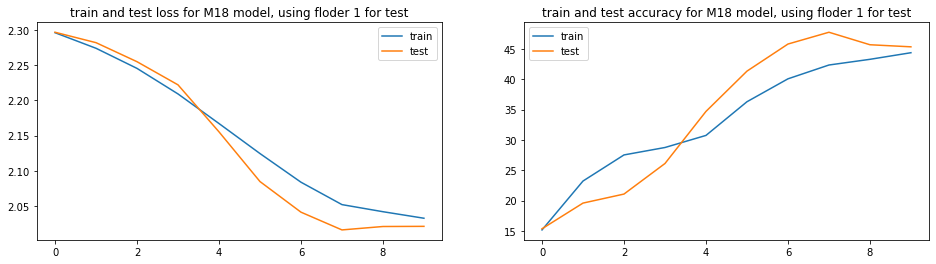

Model M18--test_floder:2 --start_time_floder:2019-12-13 15:20:34.086566
Model M18 --test_floder:2---epoch:1 --- start_time_epoch:2019-12-13 15:20:34.086896
--- Train accuracy mean: 45.00%
--- Test accuracy: 34.46%
Model M18--test_floder mean:2---epoch:1 end_time_epoch:2019-12-13 15:20:56.875137 time_running:0.3798071543375651
Model M18 --test_floder:2---epoch:2 --- start_time_epoch:2019-12-13 15:20:56.875706
--- Train accuracy mean: 46.97%
--- Test accuracy: 37.95%
Model M18--test_floder mean:2---epoch:2 end_time_epoch:2019-12-13 15:21:19.991123 time_running:0.3852618098258972
Model M18 --test_floder:2---epoch:3 --- start_time_epoch:2019-12-13 15:21:19.991509
--- Train accuracy mean: 49.29%
--- Test accuracy: 37.95%
Model M18--test_floder mean:2---epoch:3 end_time_epoch:2019-12-13 15:21:42.975136 time_running:0.3830650250116984
Model M18 --test_floder:2---epoch:4 --- start_time_epoch:2019-12-13 15:21:42.975956
--- Train accuracy mean: 51.16%
--- Test accuracy: 39.41%
Model M18--test_fl

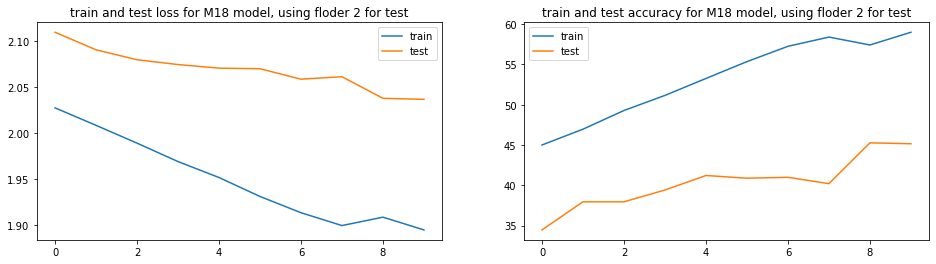

Model M18--test_floder:3 --start_time_floder:2019-12-13 15:24:23.498732
Model M18 --test_floder:3---epoch:1 --- start_time_epoch:2019-12-13 15:24:23.499126
--- Train accuracy mean: 59.23%
--- Test accuracy: 34.70%
Model M18--test_floder mean:3---epoch:1 end_time_epoch:2019-12-13 15:24:46.649126 time_running:0.3858367681503296
Model M18 --test_floder:3---epoch:2 --- start_time_epoch:2019-12-13 15:24:46.649594
--- Train accuracy mean: 60.63%
--- Test accuracy: 40.00%
Model M18--test_floder mean:3---epoch:2 end_time_epoch:2019-12-13 15:25:10.072590 time_running:0.39038840134938557
Model M18 --test_floder:3---epoch:3 --- start_time_epoch:2019-12-13 15:25:10.072977
--- Train accuracy mean: 61.97%
--- Test accuracy: 40.11%
Model M18--test_floder mean:3---epoch:3 end_time_epoch:2019-12-13 15:25:33.212912 time_running:0.38566988706588745
Model M18 --test_floder:3---epoch:4 --- start_time_epoch:2019-12-13 15:25:33.213298
--- Train accuracy mean: 62.89%
--- Test accuracy: 39.68%
Model M18--test_

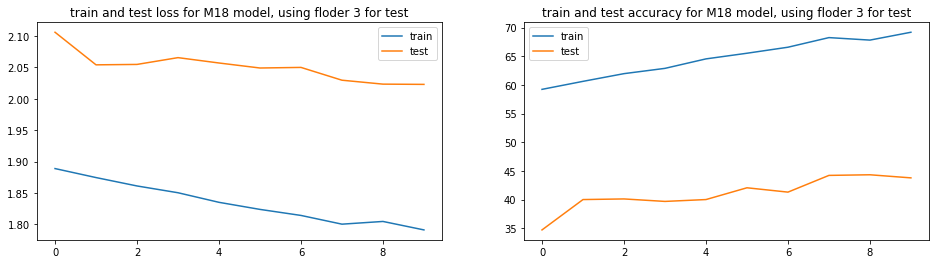

Model M18--test_floder:4 --start_time_floder:2019-12-13 15:28:16.230301
Model M18 --test_floder:4---epoch:1 --- start_time_epoch:2019-12-13 15:28:16.230670
--- Train accuracy mean: 66.00%
--- Test accuracy: 42.93%
Model M18--test_floder mean:4---epoch:1 end_time_epoch:2019-12-13 15:28:39.305997 time_running:0.3845926364262899
Model M18 --test_floder:4---epoch:2 --- start_time_epoch:2019-12-13 15:28:39.306363
--- Train accuracy mean: 67.82%
--- Test accuracy: 47.37%
Model M18--test_floder mean:4---epoch:2 end_time_epoch:2019-12-13 15:29:02.187750 time_running:0.3813608924547831
Model M18 --test_floder:4---epoch:3 --- start_time_epoch:2019-12-13 15:29:02.188285
--- Train accuracy mean: 70.03%
--- Test accuracy: 56.16%
Model M18--test_floder mean:4---epoch:3 end_time_epoch:2019-12-13 15:29:24.879395 time_running:0.37819157044092816
Model M18 --test_floder:4---epoch:4 --- start_time_epoch:2019-12-13 15:29:24.879915
--- Train accuracy mean: 72.28%
--- Test accuracy: 53.13%
Model M18--test_f

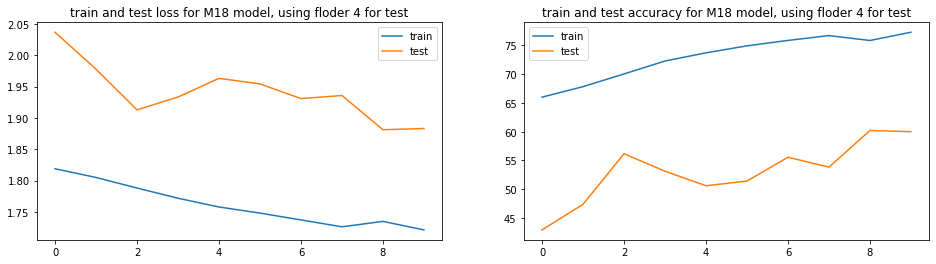

Model M18--test_floder:5 --start_time_floder:2019-12-13 15:32:07.339825
Model M18 --test_floder:5---epoch:1 --- start_time_epoch:2019-12-13 15:32:07.340167
--- Train accuracy mean: 73.70%
--- Test accuracy: 55.24%
Model M18--test_floder mean:5---epoch:1 end_time_epoch:2019-12-13 15:32:30.638575 time_running:0.3883099953333537
Model M18 --test_floder:5---epoch:2 --- start_time_epoch:2019-12-13 15:32:30.639214
--- Train accuracy mean: 74.79%
--- Test accuracy: 62.61%
Model M18--test_floder mean:5---epoch:2 end_time_epoch:2019-12-13 15:32:53.998587 time_running:0.3893301685651143
Model M18 --test_floder:5---epoch:3 --- start_time_epoch:2019-12-13 15:32:53.999325
--- Train accuracy mean: 76.39%
--- Test accuracy: 62.93%
Model M18--test_floder mean:5---epoch:3 end_time_epoch:2019-12-13 15:33:17.184400 time_running:0.3864219307899475
Model M18 --test_floder:5---epoch:4 --- start_time_epoch:2019-12-13 15:33:17.184945
--- Train accuracy mean: 77.24%
--- Test accuracy: 65.28%
Model M18--test_fl

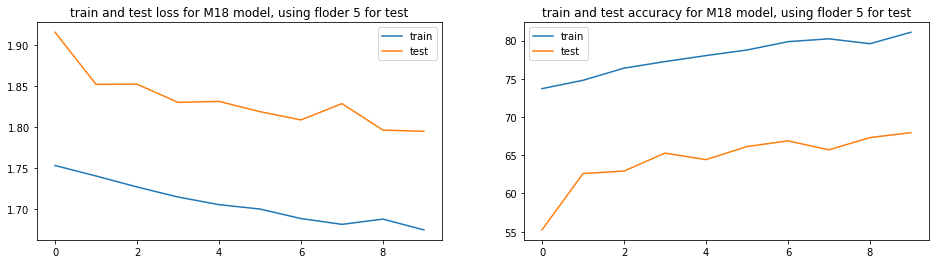

Model M18--test_floder:6 --start_time_floder:2019-12-13 15:36:00.188501
Model M18 --test_floder:6---epoch:1 --- start_time_epoch:2019-12-13 15:36:00.189242
--- Train accuracy mean: 77.66%
--- Test accuracy: 57.47%
Model M18--test_floder mean:6---epoch:1 end_time_epoch:2019-12-13 15:36:23.454134 time_running:0.38775173425674436
Model M18 --test_floder:6---epoch:2 --- start_time_epoch:2019-12-13 15:36:23.454592
--- Train accuracy mean: 79.24%
--- Test accuracy: 58.57%
Model M18--test_floder mean:6---epoch:2 end_time_epoch:2019-12-13 15:36:46.351132 time_running:0.3816141088803609
Model M18 --test_floder:6---epoch:3 --- start_time_epoch:2019-12-13 15:36:46.351482
--- Train accuracy mean: 80.00%
--- Test accuracy: 63.30%
Model M18--test_floder mean:6---epoch:3 end_time_epoch:2019-12-13 15:37:08.968735 time_running:0.37695815563201907
Model M18 --test_floder:6---epoch:4 --- start_time_epoch:2019-12-13 15:37:08.969537
--- Train accuracy mean: 80.50%
--- Test accuracy: 64.28%
Model M18--test_

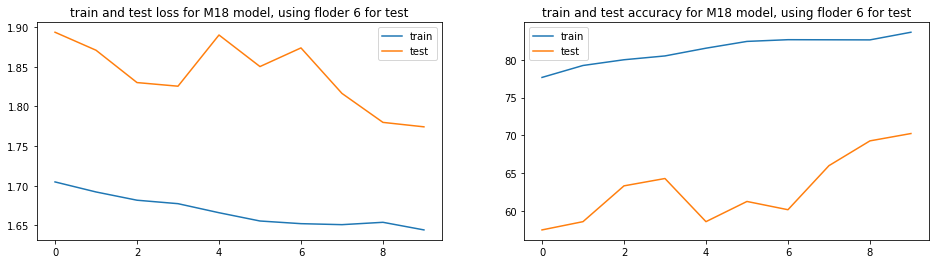

Model M18--test_floder:7 --start_time_floder:2019-12-13 15:39:48.713833
Model M18 --test_floder:7---epoch:1 --- start_time_epoch:2019-12-13 15:39:48.714518
--- Train accuracy mean: 81.15%
--- Test accuracy: 59.67%
Model M18--test_floder mean:7---epoch:1 end_time_epoch:2019-12-13 15:40:11.818799 time_running:0.3850743532180786
Model M18 --test_floder:7---epoch:2 --- start_time_epoch:2019-12-13 15:40:11.819190
--- Train accuracy mean: 82.40%
--- Test accuracy: 54.42%
Model M18--test_floder mean:7---epoch:2 end_time_epoch:2019-12-13 15:40:34.977523 time_running:0.3859766999880473
Model M18 --test_floder:7---epoch:3 --- start_time_epoch:2019-12-13 15:40:34.978071
--- Train accuracy mean: 82.96%
--- Test accuracy: 59.07%
Model M18--test_floder mean:7---epoch:3 end_time_epoch:2019-12-13 15:40:58.183216 time_running:0.3867565353711446
Model M18 --test_floder:7---epoch:4 --- start_time_epoch:2019-12-13 15:40:58.183701
--- Train accuracy mean: 82.97%
--- Test accuracy: 53.82%
Model M18--test_fl

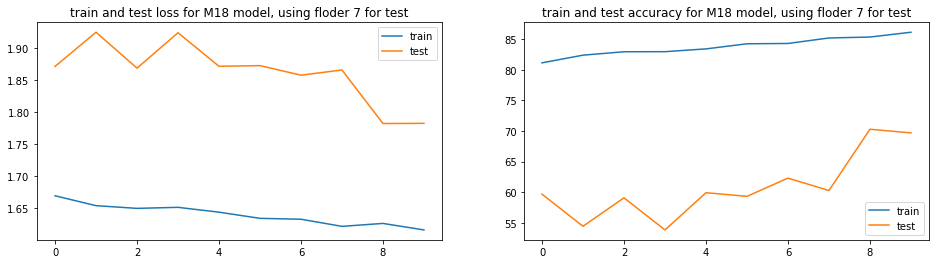

Model M18--test_floder:8 --start_time_floder:2019-12-13 15:43:40.513552
Model M18 --test_floder:8---epoch:1 --- start_time_epoch:2019-12-13 15:43:40.513886
--- Train accuracy mean: 82.40%
--- Test accuracy: 71.34%
Model M18--test_floder mean:8---epoch:1 end_time_epoch:2019-12-13 15:44:03.504955 time_running:0.383187464872996
Model M18 --test_floder:8---epoch:2 --- start_time_epoch:2019-12-13 15:44:03.505472
--- Train accuracy mean: 84.43%
--- Test accuracy: 64.02%
Model M18--test_floder mean:8---epoch:2 end_time_epoch:2019-12-13 15:44:26.568612 time_running:0.38439008394877117
Model M18 --test_floder:8---epoch:3 --- start_time_epoch:2019-12-13 15:44:26.569119
--- Train accuracy mean: 84.73%
--- Test accuracy: 67.99%
Model M18--test_floder mean:8---epoch:3 end_time_epoch:2019-12-13 15:44:49.300747 time_running:0.37886656522750856
Model M18 --test_floder:8---epoch:4 --- start_time_epoch:2019-12-13 15:44:49.301293
--- Train accuracy mean: 86.12%
--- Test accuracy: 69.11%
Model M18--test_f

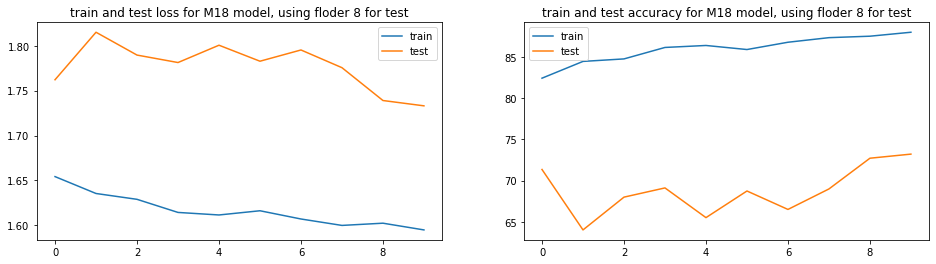

Model M18--test_floder:9 --start_time_floder:2019-12-13 15:47:30.469860
Model M18 --test_floder:9---epoch:1 --- start_time_epoch:2019-12-13 15:47:30.470200
--- Train accuracy mean: 86.19%
--- Test accuracy: 72.79%
Model M18--test_floder mean:9---epoch:1 end_time_epoch:2019-12-13 15:47:53.591442 time_running:0.38535749912261963
Model M18 --test_floder:9---epoch:2 --- start_time_epoch:2019-12-13 15:47:53.593774
--- Train accuracy mean: 86.28%
--- Test accuracy: 79.17%
Model M18--test_floder mean:9---epoch:2 end_time_epoch:2019-12-13 15:48:16.647666 time_running:0.3842361887296041
Model M18 --test_floder:9---epoch:3 --- start_time_epoch:2019-12-13 15:48:16.648146
--- Train accuracy mean: 87.11%
--- Test accuracy: 77.33%
Model M18--test_floder mean:9---epoch:3 end_time_epoch:2019-12-13 15:48:39.727447 time_running:0.3846604585647583
Model M18 --test_floder:9---epoch:4 --- start_time_epoch:2019-12-13 15:48:39.727842
--- Train accuracy mean: 87.14%
--- Test accuracy: 75.74%
Model M18--test_f

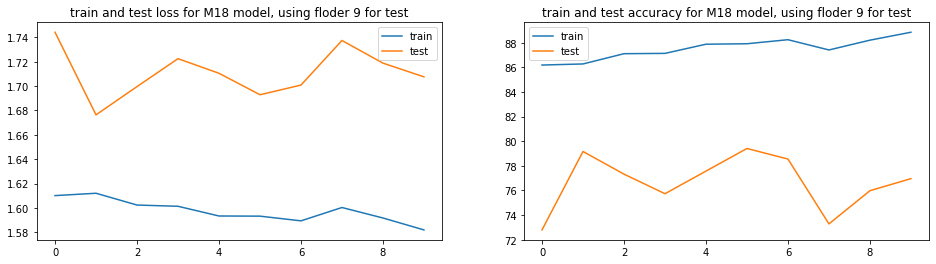

Model M18--test_floder:10 --start_time_floder:2019-12-13 15:51:20.844027
Model M18 --test_floder:10---epoch:1 --- start_time_epoch:2019-12-13 15:51:20.844311
--- Train accuracy mean: 87.49%
--- Test accuracy: 70.85%
Model M18--test_floder mean:10---epoch:1 end_time_epoch:2019-12-13 15:51:43.642514 time_running:0.3799728473027547
Model M18 --test_floder:10---epoch:2 --- start_time_epoch:2019-12-13 15:51:43.642976
--- Train accuracy mean: 88.23%
--- Test accuracy: 74.43%
Model M18--test_floder mean:10---epoch:2 end_time_epoch:2019-12-13 15:52:06.451236 time_running:0.3801419655481974
Model M18 --test_floder:10---epoch:3 --- start_time_epoch:2019-12-13 15:52:06.452135
--- Train accuracy mean: 88.88%
--- Test accuracy: 74.19%
Model M18--test_floder mean:10---epoch:3 end_time_epoch:2019-12-13 15:52:29.241258 time_running:0.37982332706451416
Model M18 --test_floder:10---epoch:4 --- start_time_epoch:2019-12-13 15:52:29.241879
--- Train accuracy mean: 89.22%
--- Test accuracy: 73.12%
Model M18

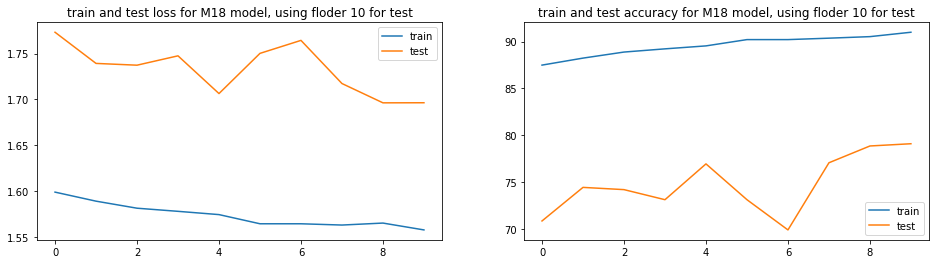

Model M18-----------end_time_model:2019-12-13 15:55:09.800149 with cross validation loss:1.8414069113986833 and cross validation accuracy:63.77336677580532


In [27]:
print(" .      ***************************************************************************************************")
print("**************************************************MODEL M18*************************************************")
print(" .      ***************************************************************************************************")
model = M18
model_train_plot(model,"M18")

 .      ***************************************************************************************************
**************************************************MODEL M34res*************************************************
 .      ***************************************************************************************************
Model M34res-----------start_time_model:2019-12-13 16:35:50.942191
Model M34res--test_floder:1 --start_time_floder:2019-12-13 16:35:50.996617
Model M34res --test_floder:1---epoch:1 --- start_time_epoch:2019-12-13 16:35:50.997378
--- Train accuracy mean: 59.60%
--- Test accuracy: 60.82%
Model M34res--test_floder mean:1---epoch:1 end_time_epoch:2019-12-13 16:36:20.381659 time_running:0.4897451639175415
Model M34res --test_floder:1---epoch:2 --- start_time_epoch:2019-12-13 16:36:20.383152
--- Train accuracy mean: 64.32%
--- Test accuracy: 67.12%
Model M34res--test_floder mean:1---epoch:2 end_time_epoch:2019-12-13 16:36:49.616789 time_running:0.487237819035848
Model M

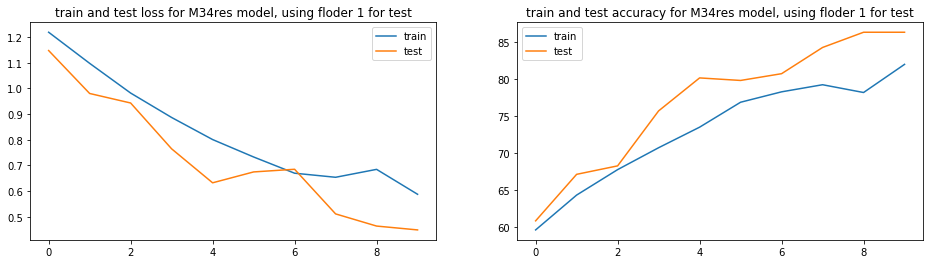

Model M34res--test_floder:2 --start_time_floder:2019-12-13 16:40:45.398628
Model M34res --test_floder:2---epoch:1 --- start_time_epoch:2019-12-13 16:40:45.399471
--- Train accuracy mean: 81.09%
--- Test accuracy: 56.98%
Model M34res--test_floder mean:2---epoch:1 end_time_epoch:2019-12-13 16:41:12.241458 time_running:0.44737380743026733
Model M34res --test_floder:2---epoch:2 --- start_time_epoch:2019-12-13 16:41:12.242204
--- Train accuracy mean: 81.85%
--- Test accuracy: 54.50%
Model M34res--test_floder mean:2---epoch:2 end_time_epoch:2019-12-13 16:41:39.023459 time_running:0.4463643749554952
Model M34res --test_floder:2---epoch:3 --- start_time_epoch:2019-12-13 16:41:39.024237
--- Train accuracy mean: 84.82%
--- Test accuracy: 51.91%
Model M34res--test_floder mean:2---epoch:3 end_time_epoch:2019-12-13 16:42:05.978316 time_running:0.44924493233362833
Model M34res --test_floder:2---epoch:4 --- start_time_epoch:2019-12-13 16:42:05.979541
--- Train accuracy mean: 86.92%
--- Test accuracy:

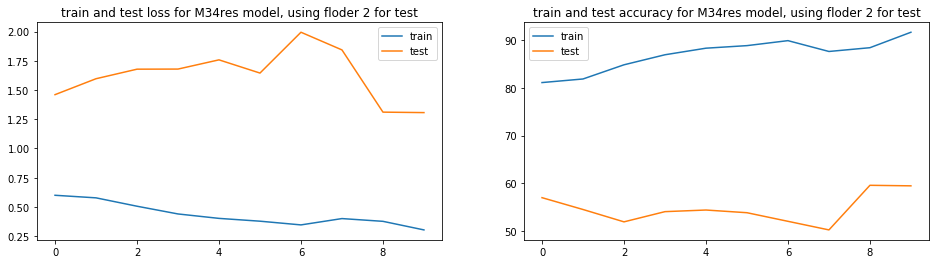

Model M34res--test_floder:3 --start_time_floder:2019-12-13 16:45:13.233439
Model M34res --test_floder:3---epoch:1 --- start_time_epoch:2019-12-13 16:45:13.234011
--- Train accuracy mean: 83.22%
--- Test accuracy: 48.54%
Model M34res--test_floder mean:3---epoch:1 end_time_epoch:2019-12-13 16:45:40.143791 time_running:0.4485026637713114
Model M34res --test_floder:3---epoch:2 --- start_time_epoch:2019-12-13 16:45:40.144483
--- Train accuracy mean: 84.96%
--- Test accuracy: 59.03%
Model M34res--test_floder mean:3---epoch:2 end_time_epoch:2019-12-13 16:46:06.697911 time_running:0.44256678024927776
Model M34res --test_floder:3---epoch:3 --- start_time_epoch:2019-12-13 16:46:06.698714
--- Train accuracy mean: 86.90%
--- Test accuracy: 46.59%
Model M34res--test_floder mean:3---epoch:3 end_time_epoch:2019-12-13 16:46:33.597918 time_running:0.44833056926727294
Model M34res --test_floder:3---epoch:4 --- start_time_epoch:2019-12-13 16:46:33.598801
--- Train accuracy mean: 89.97%
--- Test accuracy:

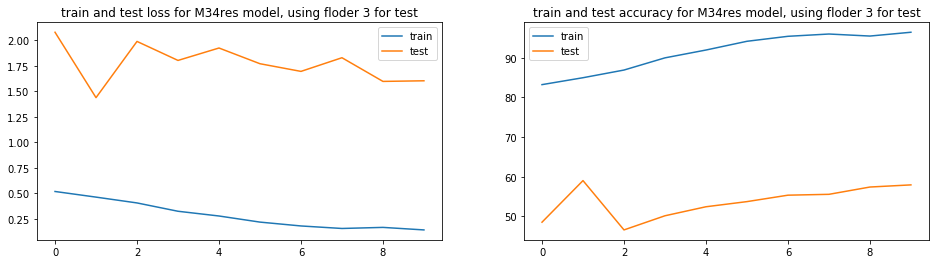

Model M34res--test_floder:4 --start_time_floder:2019-12-13 16:49:40.584375
Model M34res --test_floder:4---epoch:1 --- start_time_epoch:2019-12-13 16:49:40.585003
--- Train accuracy mean: 82.54%
--- Test accuracy: 58.69%
Model M34res--test_floder mean:4---epoch:1 end_time_epoch:2019-12-13 16:50:07.120112 time_running:0.4422603964805603
Model M34res --test_floder:4---epoch:2 --- start_time_epoch:2019-12-13 16:50:07.122221
--- Train accuracy mean: 87.96%
--- Test accuracy: 65.35%
Model M34res--test_floder mean:4---epoch:2 end_time_epoch:2019-12-13 16:50:33.785411 time_running:0.44439789454142253
Model M34res --test_floder:4---epoch:3 --- start_time_epoch:2019-12-13 16:50:33.786618
--- Train accuracy mean: 91.66%
--- Test accuracy: 66.57%
Model M34res--test_floder mean:4---epoch:3 end_time_epoch:2019-12-13 16:51:00.561218 time_running:0.44625900586446127
Model M34res --test_floder:4---epoch:4 --- start_time_epoch:2019-12-13 16:51:00.562646
--- Train accuracy mean: 93.89%
--- Test accuracy:

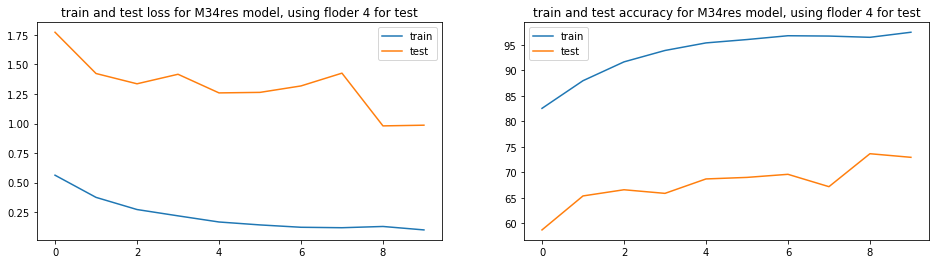

Model M34res--test_floder:5 --start_time_floder:2019-12-13 16:54:08.079461
Model M34res --test_floder:5---epoch:1 --- start_time_epoch:2019-12-13 16:54:08.080049
--- Train accuracy mean: 86.72%
--- Test accuracy: 70.19%
Model M34res--test_floder mean:5---epoch:1 end_time_epoch:2019-12-13 16:54:34.722673 time_running:0.4440511345863342
Model M34res --test_floder:5---epoch:2 --- start_time_epoch:2019-12-13 16:54:34.723460
--- Train accuracy mean: 91.48%
--- Test accuracy: 77.24%
Model M34res--test_floder mean:5---epoch:2 end_time_epoch:2019-12-13 16:55:01.476533 time_running:0.4458951950073242
Model M34res --test_floder:5---epoch:3 --- start_time_epoch:2019-12-13 16:55:01.478106
--- Train accuracy mean: 94.09%
--- Test accuracy: 75.85%
Model M34res--test_floder mean:5---epoch:3 end_time_epoch:2019-12-13 16:55:28.461321 time_running:0.44973356326421104
Model M34res --test_floder:5---epoch:4 --- start_time_epoch:2019-12-13 16:55:28.462950
--- Train accuracy mean: 96.37%
--- Test accuracy: 

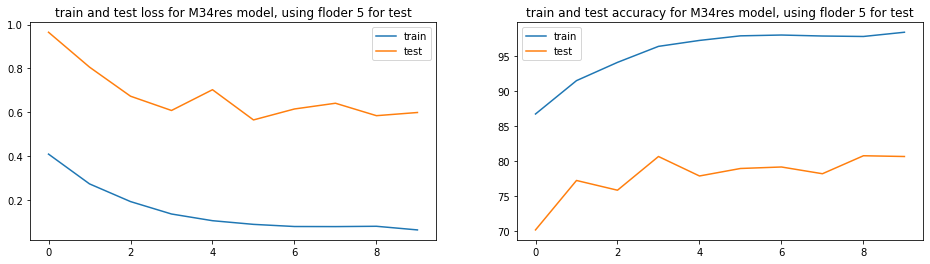

Model M34res--test_floder:6 --start_time_floder:2019-12-13 16:58:36.615742
Model M34res --test_floder:6---epoch:1 --- start_time_epoch:2019-12-13 16:58:36.616298
--- Train accuracy mean: 91.28%
--- Test accuracy: 70.72%
Model M34res--test_floder mean:6---epoch:1 end_time_epoch:2019-12-13 16:59:03.368282 time_running:0.445873498916626
Model M34res --test_floder:6---epoch:2 --- start_time_epoch:2019-12-13 16:59:03.369060
--- Train accuracy mean: 94.23%
--- Test accuracy: 75.58%
Model M34res--test_floder mean:6---epoch:2 end_time_epoch:2019-12-13 16:59:29.921940 time_running:0.4425583879152934
Model M34res --test_floder:6---epoch:3 --- start_time_epoch:2019-12-13 16:59:29.922779
--- Train accuracy mean: 97.72%
--- Test accuracy: 77.40%
Model M34res--test_floder mean:6---epoch:3 end_time_epoch:2019-12-13 16:59:56.657333 time_running:0.4455877105394999
Model M34res --test_floder:6---epoch:4 --- start_time_epoch:2019-12-13 16:59:56.658129
--- Train accuracy mean: 98.22%
--- Test accuracy: 79

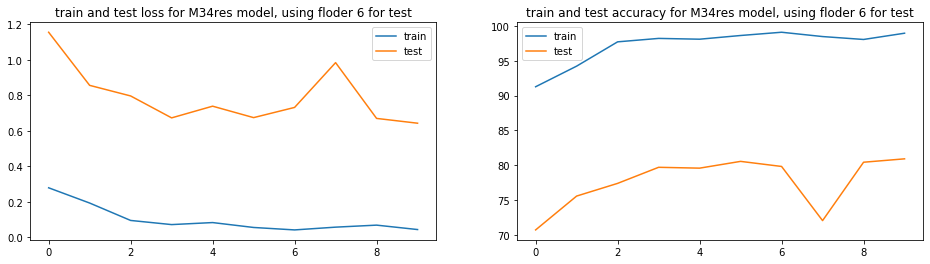

Model M34res--test_floder:7 --start_time_floder:2019-12-13 17:03:04.297958
Model M34res --test_floder:7---epoch:1 --- start_time_epoch:2019-12-13 17:03:04.298769
--- Train accuracy mean: 91.04%
--- Test accuracy: 68.02%
Model M34res--test_floder mean:7---epoch:1 end_time_epoch:2019-12-13 17:03:30.983883 time_running:0.44475945631663005
Model M34res --test_floder:7---epoch:2 --- start_time_epoch:2019-12-13 17:03:30.985426
--- Train accuracy mean: 94.70%
--- Test accuracy: 78.40%
Model M34res--test_floder mean:7---epoch:2 end_time_epoch:2019-12-13 17:03:57.938356 time_running:0.44923919836680093
Model M34res --test_floder:7---epoch:3 --- start_time_epoch:2019-12-13 17:03:57.939070
--- Train accuracy mean: 97.25%
--- Test accuracy: 81.03%
Model M34res--test_floder mean:7---epoch:3 end_time_epoch:2019-12-13 17:04:24.682575 time_running:0.4457353393236796
Model M34res --test_floder:7---epoch:4 --- start_time_epoch:2019-12-13 17:04:24.683436
--- Train accuracy mean: 98.54%
--- Test accuracy:

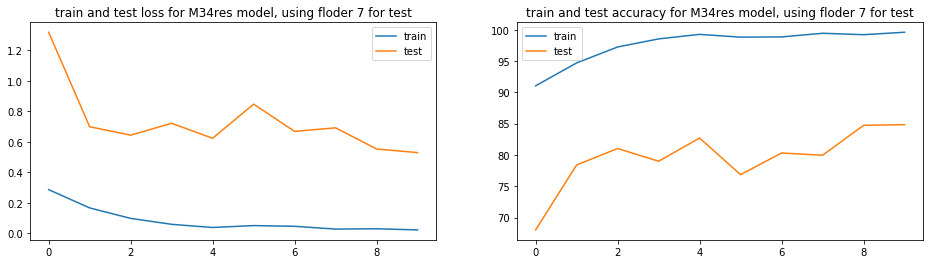

Model M34res--test_floder:8 --start_time_floder:2019-12-13 17:07:32.626941
Model M34res --test_floder:8---epoch:1 --- start_time_epoch:2019-12-13 17:07:32.627877
--- Train accuracy mean: 96.88%
--- Test accuracy: 85.36%
Model M34res--test_floder mean:8---epoch:1 end_time_epoch:2019-12-13 17:07:59.333832 time_running:0.4451071778933207
Model M34res --test_floder:8---epoch:2 --- start_time_epoch:2019-12-13 17:07:59.335295
--- Train accuracy mean: 97.54%
--- Test accuracy: 83.00%
Model M34res--test_floder mean:8---epoch:2 end_time_epoch:2019-12-13 17:08:25.918109 time_running:0.4430604894955953
Model M34res --test_floder:8---epoch:3 --- start_time_epoch:2019-12-13 17:08:25.918982
--- Train accuracy mean: 98.89%
--- Test accuracy: 87.59%
Model M34res--test_floder mean:8---epoch:3 end_time_epoch:2019-12-13 17:08:52.884502 time_running:0.44943735202153523
Model M34res --test_floder:8---epoch:4 --- start_time_epoch:2019-12-13 17:08:52.886386
--- Train accuracy mean: 99.48%
--- Test accuracy: 

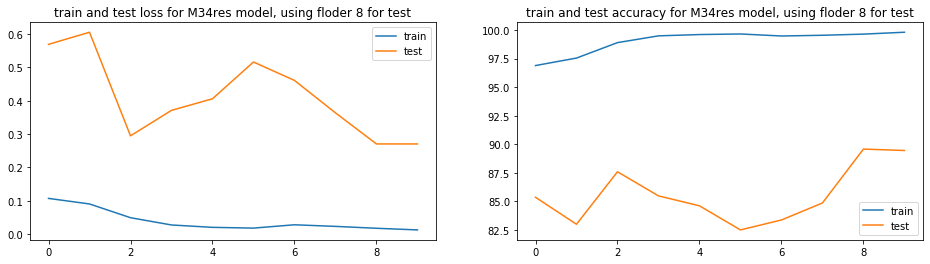

Model M34res--test_floder:9 --start_time_floder:2019-12-13 17:12:01.748370
Model M34res --test_floder:9---epoch:1 --- start_time_epoch:2019-12-13 17:12:01.748964
--- Train accuracy mean: 99.36%
--- Test accuracy: 84.93%
Model M34res--test_floder mean:9---epoch:1 end_time_epoch:2019-12-13 17:12:28.380537 time_running:0.4438671787579854
Model M34res --test_floder:9---epoch:2 --- start_time_epoch:2019-12-13 17:12:28.381978
--- Train accuracy mean: 98.41%
--- Test accuracy: 76.23%
Model M34res--test_floder mean:9---epoch:2 end_time_epoch:2019-12-13 17:12:54.903369 time_running:0.4420340617497762
Model M34res --test_floder:9---epoch:3 --- start_time_epoch:2019-12-13 17:12:54.904540
--- Train accuracy mean: 99.75%
--- Test accuracy: 80.15%
Model M34res--test_floder mean:9---epoch:3 end_time_epoch:2019-12-13 17:13:21.744471 time_running:0.4473415454228719
Model M34res --test_floder:9---epoch:4 --- start_time_epoch:2019-12-13 17:13:21.745425
--- Train accuracy mean: 99.87%
--- Test accuracy: 8

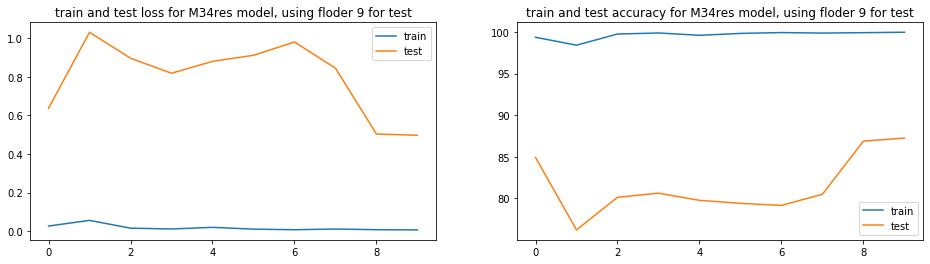

Model M34res--test_floder:10 --start_time_floder:2019-12-13 17:16:28.600100
Model M34res --test_floder:10---epoch:1 --- start_time_epoch:2019-12-13 17:16:28.600618
--- Train accuracy mean: 98.37%
--- Test accuracy: 84.47%
Model M34res--test_floder mean:10---epoch:1 end_time_epoch:2019-12-13 17:16:55.503347 time_running:0.44838536183039346
Model M34res --test_floder:10---epoch:2 --- start_time_epoch:2019-12-13 17:16:55.504157
--- Train accuracy mean: 99.53%
--- Test accuracy: 84.23%
Model M34res--test_floder mean:10---epoch:2 end_time_epoch:2019-12-13 17:17:22.151717 time_running:0.4441370089848836
Model M34res --test_floder:10---epoch:3 --- start_time_epoch:2019-12-13 17:17:22.152494
--- Train accuracy mean: 99.68%
--- Test accuracy: 82.20%
Model M34res--test_floder mean:10---epoch:3 end_time_epoch:2019-12-13 17:17:48.835541 time_running:0.4447274963061015
Model M34res --test_floder:10---epoch:4 --- start_time_epoch:2019-12-13 17:17:48.836342
--- Train accuracy mean: 99.08%
--- Test ac

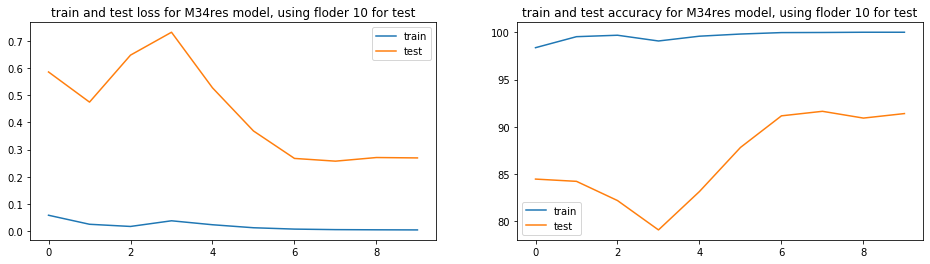

Model M34res-----------end_time_model:2019-12-13 17:20:54.460447 with cross validation loss:0.6935562915035656 and cross validation accuracy:79.3611719959876


In [30]:
print(" .      ***************************************************************************************************")
print("**************************************************MODEL M34res*************************************************")
print(" .      ***************************************************************************************************")
model = M34res
model_train_plot(model,"M34res")